# Washington BIKE SHARING PREDICTION - REWRITE IN DASK
 
## Dominik Thausing

Originally: Group E | O2 - MBD Spring 2019

## Instructions

### Rewrite the Bike Sharing analysis using Dask
(Even if the original analysis was done in group, this should be done individually)

### Submission format: 
A .zip produced by '$ git archive master --format=zip -o LastName_FirstName_Dask.zip' and a link to the GitHub repository, which must be public right after the deadline.
The objective is to rewrite the Bike Sharing analysis done in the Python for Statistical Programming subject using Dask data structures and ecosystem instead of plain pandas.
The reasons for choosing this are:
- The dataset is comparatively small, and the extra computing time is given by feature engineeering and model selection, which lowers the risk
- Everybody has performed this analysis and is relatively familiar with it, which makes it easier than carrying a data science project from scratch, given the time constraints
- Rewriting an existing analysis to make it more performant is more aligned with the objectives of the subject and reflects more real world escenarios
- The "business objectives" are more clear than in the group assignment

### The maximum score of the assignment is 4 points and the grading will be as follows:
- Creation of a git repository with a proper README, incremental commits, and some sort of automatic or programmatic download of the data before the analysis (1 point). Notice that the data should not be checked out in the repository. Including data files in git repositories is considered a bad practice.
- Use of dask.dataframe and distributed.Client for all the data manipulation (2 points). Remember that calling .compute() in a Dask DataFrame turns it into a pandas dataframe, which resides in RAM and loses the distributed advantages. The more Dask structures are used, the higher the grade.
- Use of Dask-ML for distributed training and model selection https://ml.dask.org/ (1 point). See below for inspiration.

### Useful links:
- Putting everything in a pipeline https://tomaugspurger.github.io/scalable-ml-01.html
- Why Dask-ML is faster than sklearn GridSearchCV for model selection https://jcrist.github.io/introducing-dask-searchcv.html
- JupyterHub on Hadoop https://jcrist.github.io/jupyterhub-on-hadoop/index.html

As you can see, the assignment is more open ended. Use this as a opportunity to explore, and don't be afraid of recording failed experiments in the notebook, if they are properly explained and described.

Below You can find the original Instructions of the assignment:

## General Approach
## 0. Original Instructions
## 1. EDA
### 1.2 Basic satistics on numerical variables
### 1.3 Data Quality
### 1.4 Visual Analysis
### 1.5 Correlations
## 2 Feature Engineering and Selection
### 2.1 Feature Creation
### 2.2 Feature Selection
## 3 Machine Learning Models
### 3.1 Linear Reg Trial on Original Dataset hour_df
### 3.2 Linear Reg Trial on prepared Dataset
### 3.3 One hot encoding
### 3.4 Split Dummified Dataset
### 3.5 Linear Reg for Dummified dataset
### 3.6 Ridge Reg
### 3.7 Lasso Reg
### 3.8 Random Forest
### 3.9 Gradient Boosting
### 3.10 XGBoost
## 4 Model Optimization
### 4.1 Random Forest
### 4.2 Gradient Boosting
### 4.3 XGBoost
### 4.4 Stacking
## 5 Conclusion
### 5.1 Crossvalidation for final model
### 5.2 Best prediction



## Original Instructions
Predict the total number of bicycle users on an hourly basis.
https://www.kaggle.com/marklvl/bike-sharing-dataset/downloads/Bike-Sharing-Dataset.zip/1
(Overview: https://www.kaggle.com/marklvl/bike-sharing-dataset/home)
Submission format: One Jupyter notebook (3_Bike-Sharing_GroupN.ipynb)
Please do not submit:
- A zip file
- A link to Google CoLab
- A file with the wrong extension
- A Python script
### Task description:
- Training data: whole 2011 and first 3 quarters of 2012.
- Test data: 4th quarter of 2012.  Do not fit your models with these data! They should just be used to see how good/bad your model predictions are.
- Error metric: R2 score (scikit-learn's default for regression).
- Features to use: at least the ones present in the data (except for cnt). Do not use both casual and registered columns, as cnt=casual+registered (you may use one, but not both). Additionally, you can use other sources of data you deem appropriate to predict from extra features.
- Groups: default groups for this term. You can split work as you consider best, but make sure each and every member is able to explain details on what was done throughout the project, even not their part.
### Grading criteria:
As explained in the syllabus, the project report (the submission in the form of a Jupyter notebook) weighs 30 % of the overall grade of the subject, while the presentation amounts for 20 %. For this task there are no detailed, explicit steps to be followed, but broad elements expected to be present.
Report (10 points):
- Exploratory Data Analysis (descriptive analytics) (4 points)
    - Ensuring data quality (correctness, consistency, missing values, outliers...).
    - Plotting clear and meaningful figures.
    - Giving insights on what seems relevant for prediction and what does not.
    - Bonus points for:
        - Studying the influence of combinations of features (not just individual features).
        - Checking possibly redundant variables via correlations.
        - Incorporating additional sources of data + their analysis. 
- Machine Learning (predictive analytics) (5 points)
    - Choosing sensible models (linear and non-linear).
    - Tuning model parameters with validation (either with a fixed validation set or with cross-validation).
    - Taking advantage of pipelines whenever possible.
    - Obtaining accurate predictions in test (measured with R2 score).
    - Plotting predictions vs. reality for additional insights.
    - Bonus points for:
        - Combining several models (ensembles, stacking...).
        - Plotting validation results to justify further choices (parameter ranges, other validations...).
        - Following an incremental approach (baseline models first, then more complex models, then combining models...).
        - Iterating the whole process if incorporating additional data.
- Work description (1 point):
    - Work division and planning
    - Steps finally followed
    - Results obtained after those steps
    - Conclusions and further work

Exposition in class (general overview of your project and results, approx. 20 minutes per group):
- Clarity, conciseness, quality of content & delivery
- Answering final questions (posed by teacher and/or other groups)


## 1. Explanatory Data Analysis

### 1.1 Loading and inspecting the data

In [1]:
# setting the seed for reproducability
import random
random.seed(21)

Create Dask client:

In [2]:
# my computer has 4 cores, thus I use 3 to not overwork it, if other processes are running simultanously
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=1,
                n_workers=3, memory_limit='2GB')
client

<Client: scheduler='inproc://192.168.1.38/28896/1' processes=3 cores=3>

Import dask.array and dask.dataframe:

In [3]:
import numpy as np

In [4]:
import dask
import dask.array as da
import dask.dataframe as dd
df = dask.datasets.timeseries()

Importing necessary libraries.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Loading the dataset with the hourly data for the usage of bike-sharing in Washington.

In [6]:
# load the hourly dataset

#hour_df = dd.read_csv('https://docs.google.com/spreadsheets/d/1TE_AXfr2_qMBObQ09gJ5giGe7T8W_VEZXLsk7UBVhZU/edit')

hour_df = dd.read_csv('hour.csv')

hour_df = hour_df.drop("instant", axis=1)  # drop the column instance as the instance will not provide any information

hour_df.head(5)  # take a first look at the variables

dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  casual  registered  cnt  
0  0.24  0.2879  0.81        0.0       3          13   16  
1  0.22  0.2727  0.80        0.0       8          32   40  
2  0.22  0.2727  0.80        0.0       5          27   32  
3  0.24  0.2879  0.75        0.0       3          10   13  
4  0.24  0.2879  0.75        0.0       0           1    1

#### Short data description (copied from the web )

**Original columns:**

- weathersit:
1: Clear, Few clouds, Partly cloudy,
2: Mist and Cloudy, Mist and Broken clouds, Mist and Few clouds, Mist
3: Light Snow, Light Rain and Thunderstorm and Scattered clouds, Light Rain an dScattered clouds
4: Heavy Rain and Ice Pallets and Thunderstorm and Mist, Snow and Fog
instant: record index

- dteday: date
- season: season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: year (0: 2011, 1:2012)
- mnth: month ( 1 to 12)
- holiday: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday: day of the week
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- temp: Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### General overview and renaming
Lets check if all the variables already have the correct datatype.

In [7]:
hour_df.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 2.1+ MB


After this we are renaming columns to have more interpretable and understandable column names and change their datatypes accordingly.

In [8]:
# Renaming columns names to more readable names
hour_df= hour_df.rename(
    columns={
        "dteday": "datetime",
        "holiday": "is_holiday",
        "workingday": "is_workingday",
        "hum": "humidity",
        "mnth": "month",
        "hr": "hour",
        "yr": "year",
    }
)

# Setting proper data types
# date time conversion
hour_df["datetime"] = dd.to_datetime(hour_df.datetime)

# categorical variables
hour_df["season"] = hour_df.season.astype("category")
hour_df["is_holiday"] = hour_df.is_holiday.astype("category")
hour_df["weekday"] = hour_df.weekday.astype("category")
hour_df["weathersit"] = hour_df.weathersit.astype("category")
hour_df["is_workingday"] = hour_df.is_workingday.astype("category")
hour_df["month"] = hour_df.month.astype("category")
hour_df["year"] = hour_df.year.astype("category")
hour_df["hour"] = hour_df.hour.astype("category")

Lets have a short look at our new column names:

In [9]:
hour_df.head(1)

datetime season year month hour is_holiday weekday is_workingday  \
0 2011-01-01      1    0     1    0          0       6             0   

  weathersit  temp   atemp  humidity  windspeed  casual  registered  cnt  
0          1  0.24  0.2879      0.81        0.0       3          13   16

And wheither data types are correct now.

In [10]:
hour_df.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
datetime         17379 non-null datetime64[ns]
season           17379 non-null category
year             17379 non-null category
month            17379 non-null category
hour             17379 non-null category
is_holiday       17379 non-null category
weekday          17379 non-null category
is_workingday    17379 non-null category
weathersit       17379 non-null category
temp             17379 non-null float64
atemp            17379 non-null float64
humidity         17379 non-null float64
windspeed        17379 non-null float64
casual           17379 non-null int64
registered       17379 non-null int64
cnt              17379 non-null int64
dtypes: category(8), datetime64[ns](1), float64(4), int64(3)
memory usage: 1.2 MB


And also check the shape of it.

In [11]:
# so we have 17379 rows(observations) and 16 columns (features)
hour_df.compute().shape

(17379, 16)

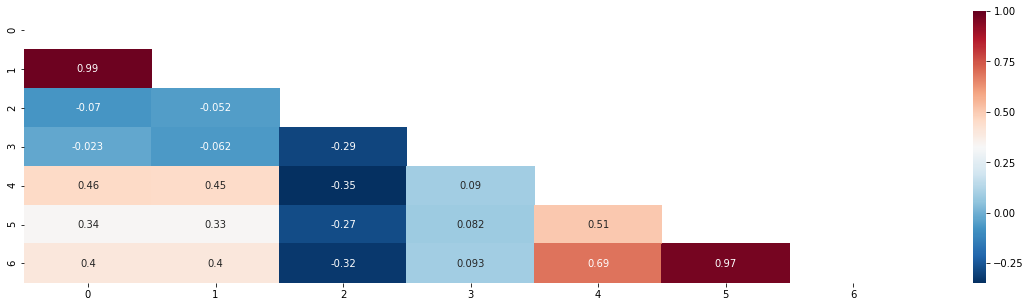

In [12]:
plt.figure(figsize=(20, 5))
mask = np.zeros_like(hour_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hour_df.corr(), cmap="RdBu_r", mask=mask, annot=True)

### 1.2 Basic satistics on numerical variables

To get a understanding of the dataset we first have a look at its statistics, this will help us too get a general understanding of how our data looks like.

In [13]:
hour_df.describe().compute().round(2)

temp     atemp  humidity  windspeed    casual  registered       cnt
count  17379.00  17379.00  17379.00   17379.00  17379.00    17379.00  17379.00
mean       0.50      0.48      0.63       0.19     35.68      153.79    189.46
std        0.19      0.17      0.19       0.12     49.31      151.36    181.39
min        0.02      0.00      0.00       0.00      0.00        0.00      1.00
25%        0.34      0.33      0.48       0.10      4.00       34.00     40.00
50%        0.50      0.48      0.63       0.19     17.00      115.00    142.00
75%        0.66      0.62      0.78       0.25     48.00      220.00    281.00
max        1.00      1.00      1.00       0.85    367.00      886.00    977.00

Looking at the skewness already indicates that we might have to take actions in the feature processing part of our EDA.

In [14]:
hour_df.compute().skew()

temp         -0.006021
atemp        -0.090429
humidity     -0.111287
windspeed     0.574905
casual        2.499237
registered    1.557904
cnt           1.277412
dtype: float64

### 1.3 Data Quality

#### Missing Values
Checking for null values shows us that we don't have any missing values.

In [15]:
hour_df.compute().isnull().sum()

datetime         0
season           0
year             0
month            0
hour             0
is_holiday       0
weekday          0
is_workingday    0
weathersit       0
temp             0
atemp            0
humidity         0
windspeed        0
casual           0
registered       0
cnt              0
dtype: int64

#### Checking for outliers

As we can see, the variable windspeed has a considerable amount of outliers which might affect our predictions and therefore need to be taken care of. 
From the boxplot of the "cnt" variable - our target varible - as well as the previous violin plot, we probably need to arrange the skewness of this variable. 
Now looking at outliers per hour, we see that most of them are located between hours 10am-15pm and 23pm to 3am. 

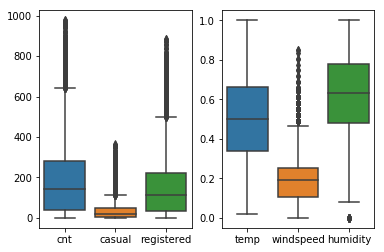

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.boxplot(data=hour_df.compute()[["cnt", "casual", "registered"]], ax=ax1)
sns.boxplot(data=hour_df.compute()[["temp", "windspeed", "humidity"]], ax=ax2)

[Text(0.5, 1.0, 'Checking for outliers in day hours')]

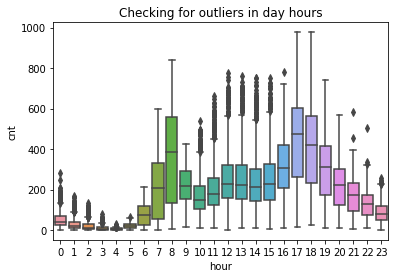

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data=hour_df.compute()[["cnt", "hour"]], x="hour", y="cnt", ax=ax)
ax.set(title="Checking for outliers in day hours")

#### Arranging outliers

Lets have a look at the IQR for the variable "windspeed".

In [18]:
from scipy import stats
Q1 = hour_df["windspeed"].quantile(0.25)
Q3 = hour_df["windspeed"].quantile(0.75)
IQR = Q3 - Q1
print(IQR.compute())

0.1492


Using the IQR we will remove outliers.

In [19]:
hour_df_out = hour_df[
    ~(
        (hour_df["windspeed"] < (Q1 - 3.6 * IQR))
        | (hour_df["windspeed"] > (Q3 + 3.6 * IQR))
    )
]
hour_df_out.compute().shape

(17374, 16)

As we can see, we have removed 5 rows with outliers!

In [20]:
hour_df.compute().shape

(17379, 16)

### 1.4 Visual Analysis

#### Distribution of numerical variables
In the first step of our visual interpretation we want to understand how our numerical variables are distributed. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c233627b8>,
      dtype=object)

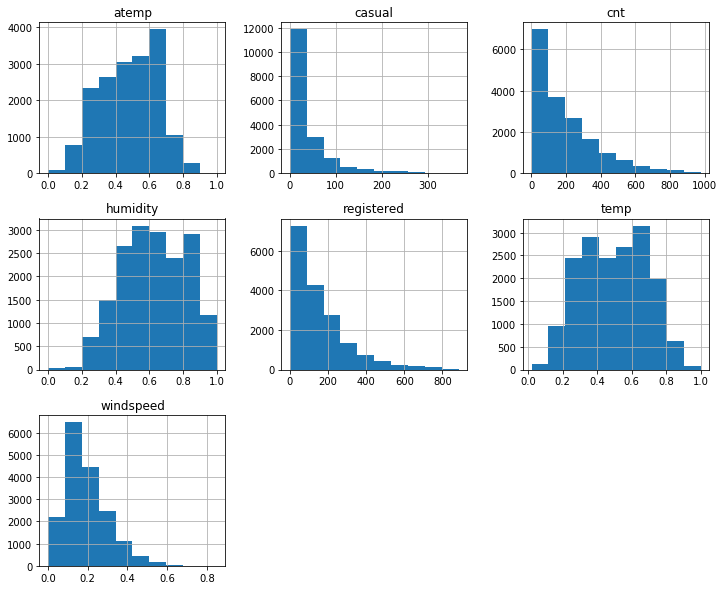

In [21]:
# view distribution of features
hour_df.compute().hist(figsize=(12, 10))

#### Yearly distribution of rentals
Next we check how our target variable ("cnt") is distributed across the two years 0 and 1 ( which equals year 2011 and 2012, respectively).

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


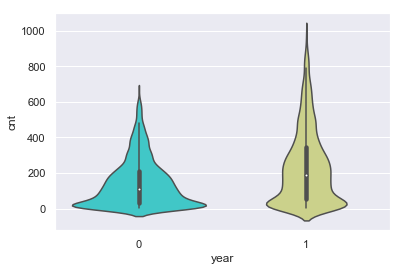

In [22]:
sns.set()
sns.violinplot("year", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

#### Seasonal distribution of rentals (average)
Next have a look if there is a seasonal component in our dataset. As a fact, usage peeks during summer and fall, which makes sense. (for casual users)

Text(0.5, 1.0, 'Number of bikes rented per season')

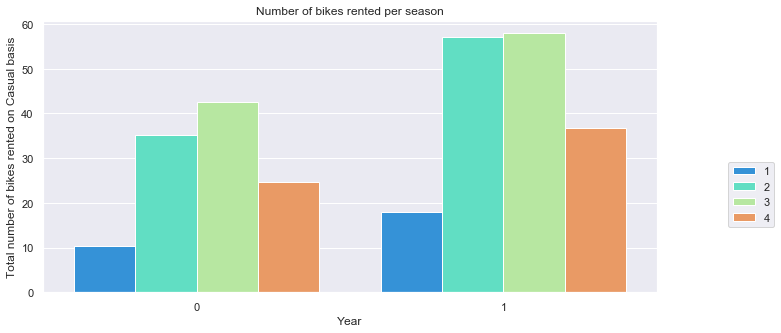

In [23]:
sns.set()
plt.figure(figsize=(11, 5))
sns.barplot("year", "casual", hue="season", data=hour_df.compute(), palette="rainbow", ci=None)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on Casual basis")
plt.title("Number of bikes rented per season")

The same we do for registered users and get a similar output.

Text(0.5, 1.0, 'Number of bikes rented per season')

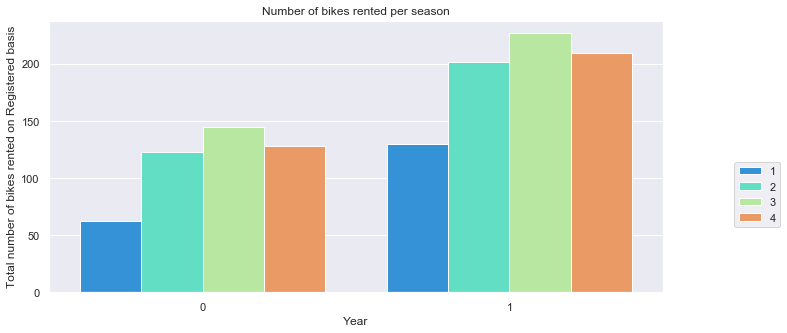

In [24]:
sns.set()
plt.figure(figsize=(11, 5))
sns.barplot(
    "year", "registered", hue="season", data=hour_df.compute(), palette="rainbow", ci=None
)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Year")
plt.ylabel("Total number of bikes rented on Registered basis")
plt.title("Number of bikes rented per season")

#### Seasonal distribution of rentals (sum)
And finally we can also look at our varibale "cnt" to understand that users in general peaks in summer and fall.

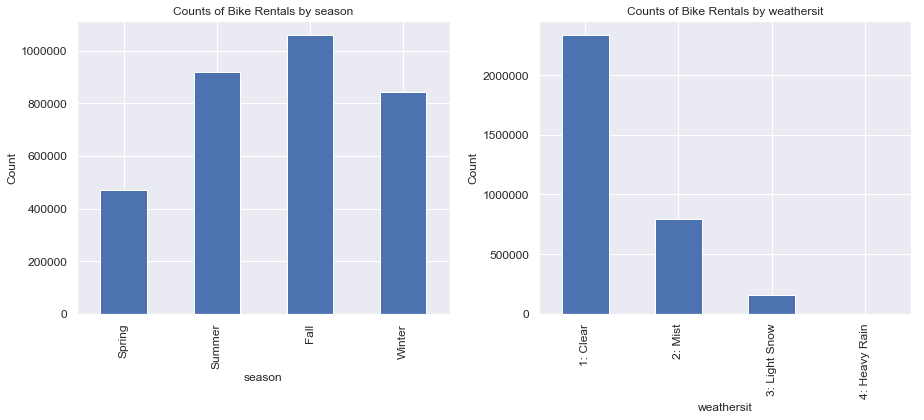

In [25]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

ax1 = (
    hour_df_out.compute()[["season", "cnt"]]
    .groupby(["season"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        title="Counts of Bike Rentals by season",
        stacked=True,
        fontsize=12,
        ax=ax1,
    )
)
ax1.set_xlabel("season", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.set_xticklabels(["Spring", "Summer", "Fall", "Winter"])

ax2 = (
    hour_df_out.compute()[["weathersit", "cnt"]]
    .groupby(["weathersit"])
    .sum()
    .reset_index()
    .plot(
        kind="bar",
        legend=False,
        stacked=True,
        title="Counts of Bike Rentals by weathersit",
        fontsize=12,
        ax=ax2,
    )
)

ax2.set_xlabel("weathersit", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_xticklabels(["1: Clear", "2: Mist", "3: Light Snow", "4: Heavy Rain"])

f.tight_layout()

#### Monthly distribution of rentals (average)
The results we get match with the seasonal analysis above.

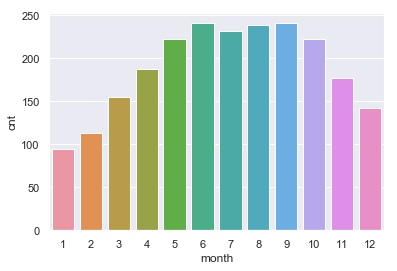

In [26]:
sns.set()
sns.barplot("month", "cnt", data=hour_df_out.compute(), ci=None)

Splitting for whether the day is a workday or not gives us useful insights.

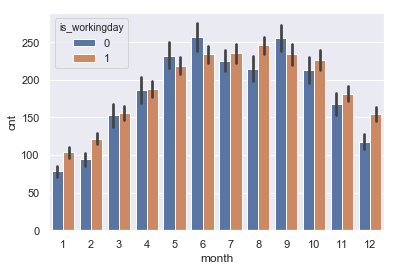

In [27]:
sns.barplot(x="month", y="cnt", hue="is_workingday", data=hour_df_out.compute())
plt.show()

Additionally we check how the year influences the average and see that the average usage in year 2012 was always higher (ligically if the business is growing).

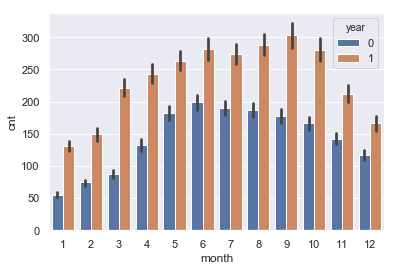

In [28]:
sns.barplot(x="month", y="cnt", hue="year", data=hour_df_out.compute())
plt.show()

#### Hourly distribution of rentals over month (average)
Now lets have a look how the average usage changes over month for each season:

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

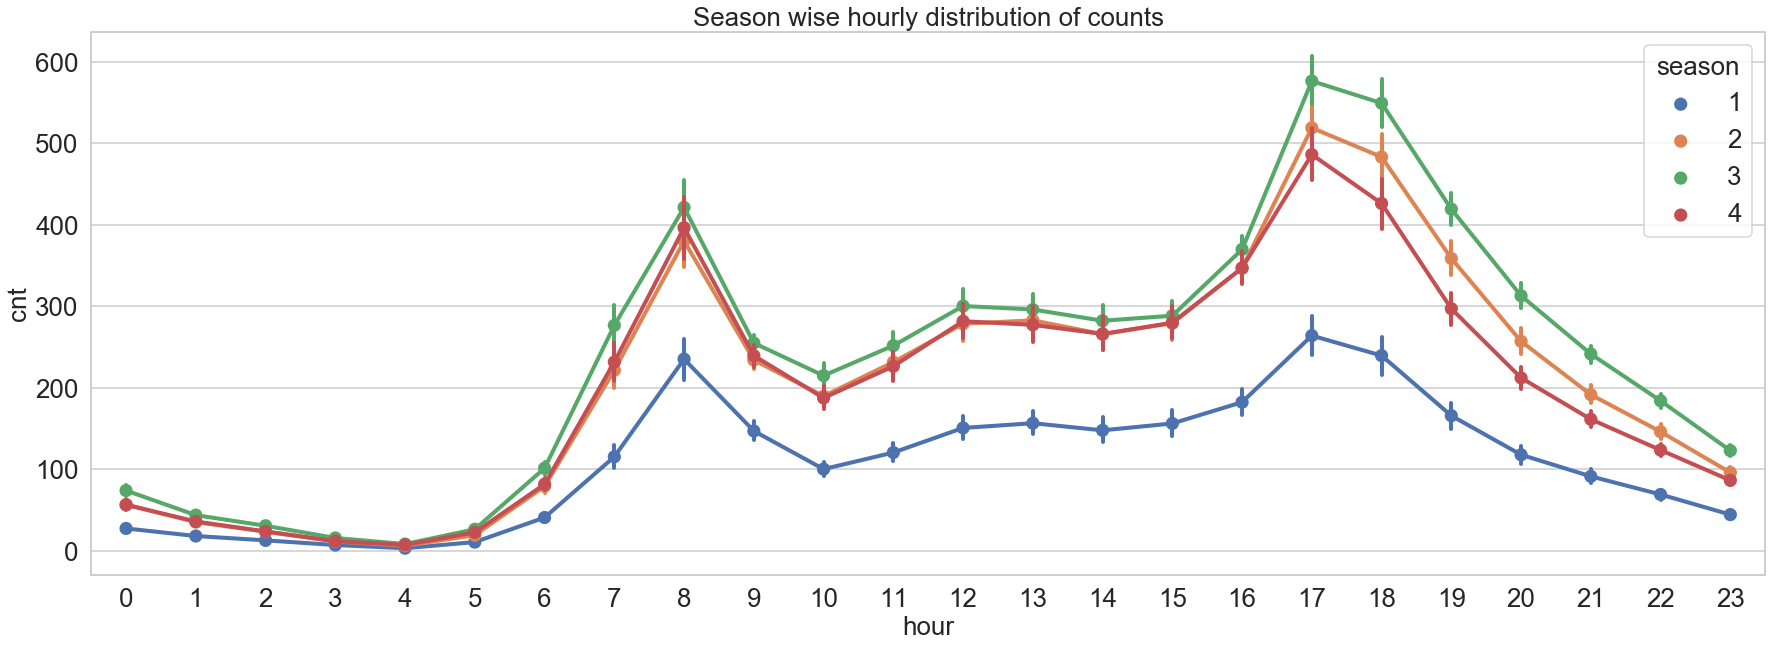

In [29]:
# Configuring plotting visual and sizes
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}

plt.rcParams.update(params)

fig, ax = plt.subplots()
sns.pointplot(
    data=hour_df_out.compute()[["hour", "cnt", "season"]], x="hour", y="cnt", hue="season", ax=ax
)
ax.set(title="Season wise hourly distribution of counts")

#### Daily distribution of rentals (average)
Daily peaks occur in the early morning (7-9) and late afternoon/evening (16-20).

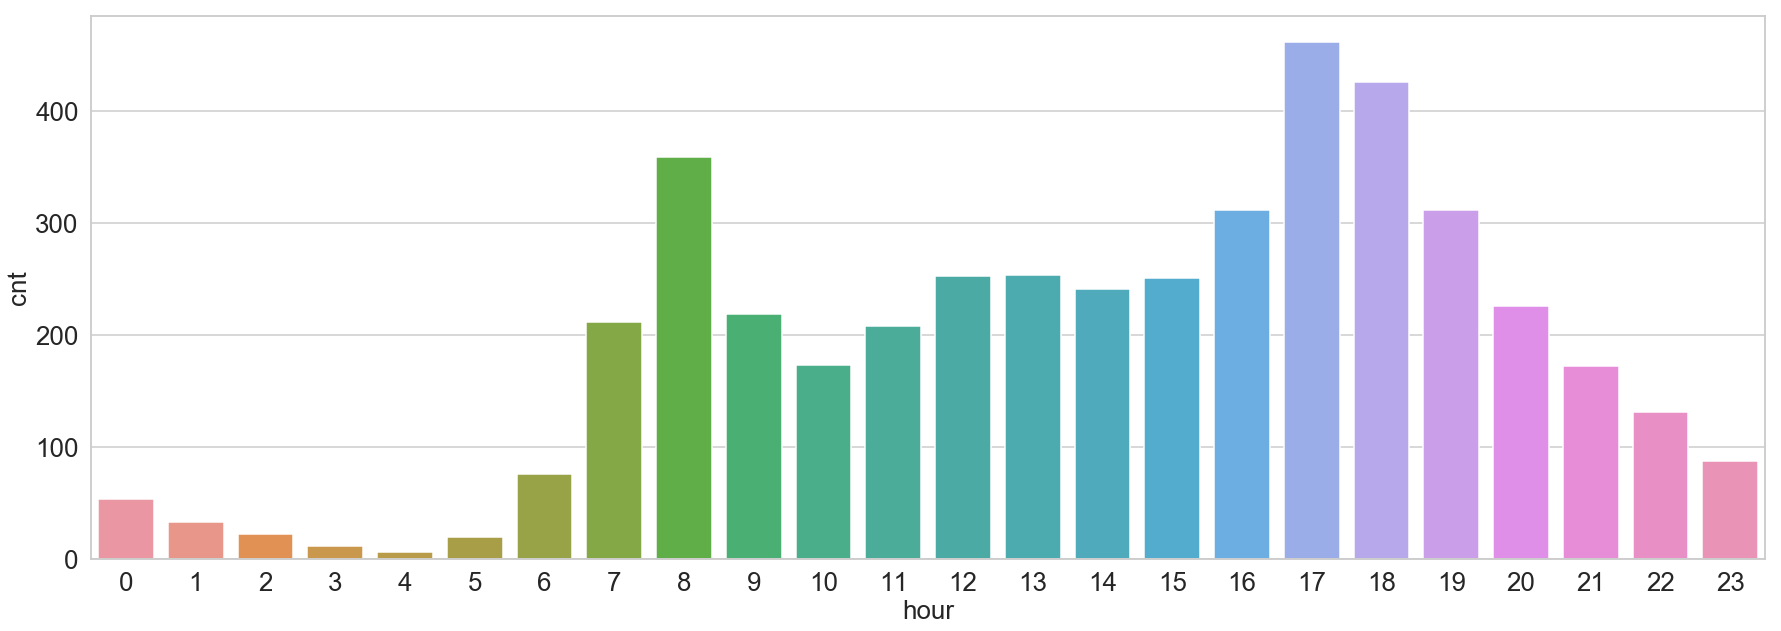

In [30]:
sns.barplot("hour", "cnt", data=hour_df_out.compute(), ci=None)

#### Weekday distribution of rentals (average)

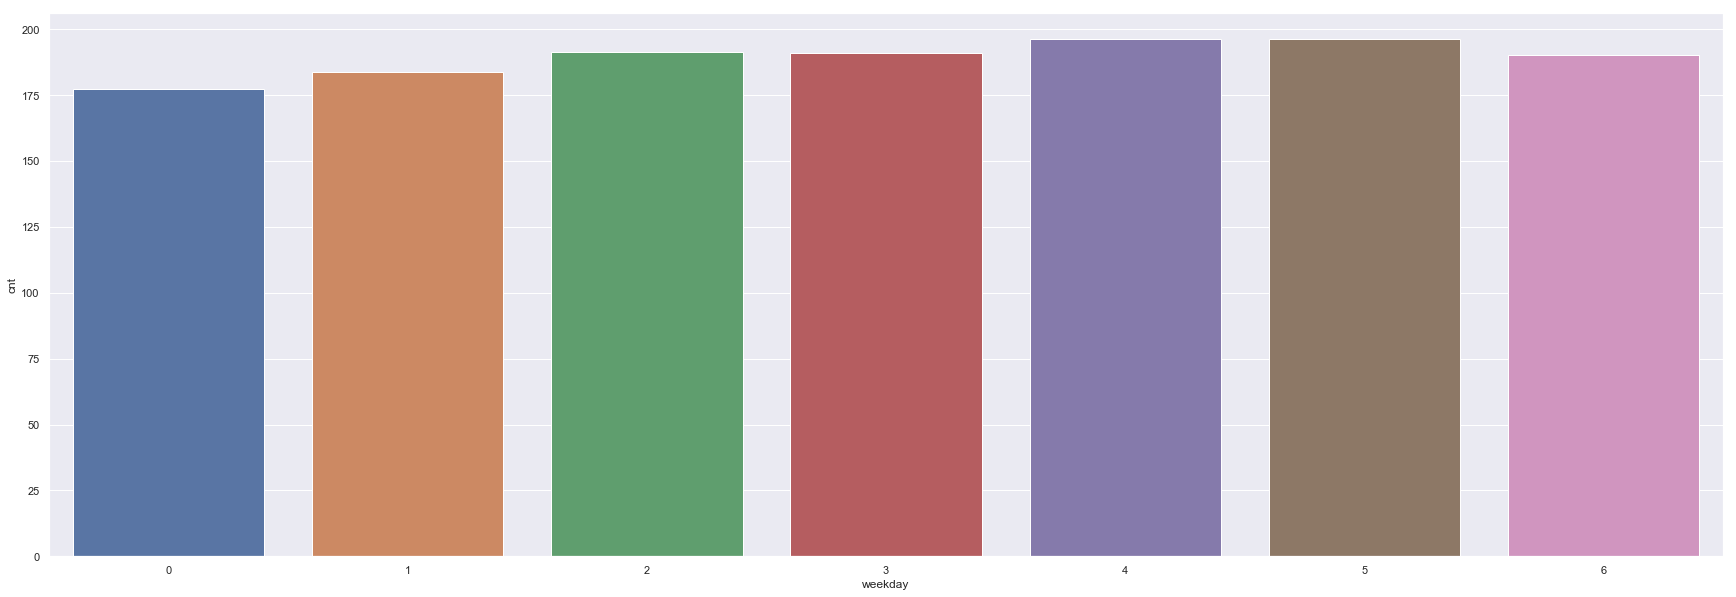

In [31]:
sns.set()
sns.barplot("weekday", "cnt", data=hour_df_out.compute(), ci=None)

#### Hourly distribution of rentals per weekdays (average)

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

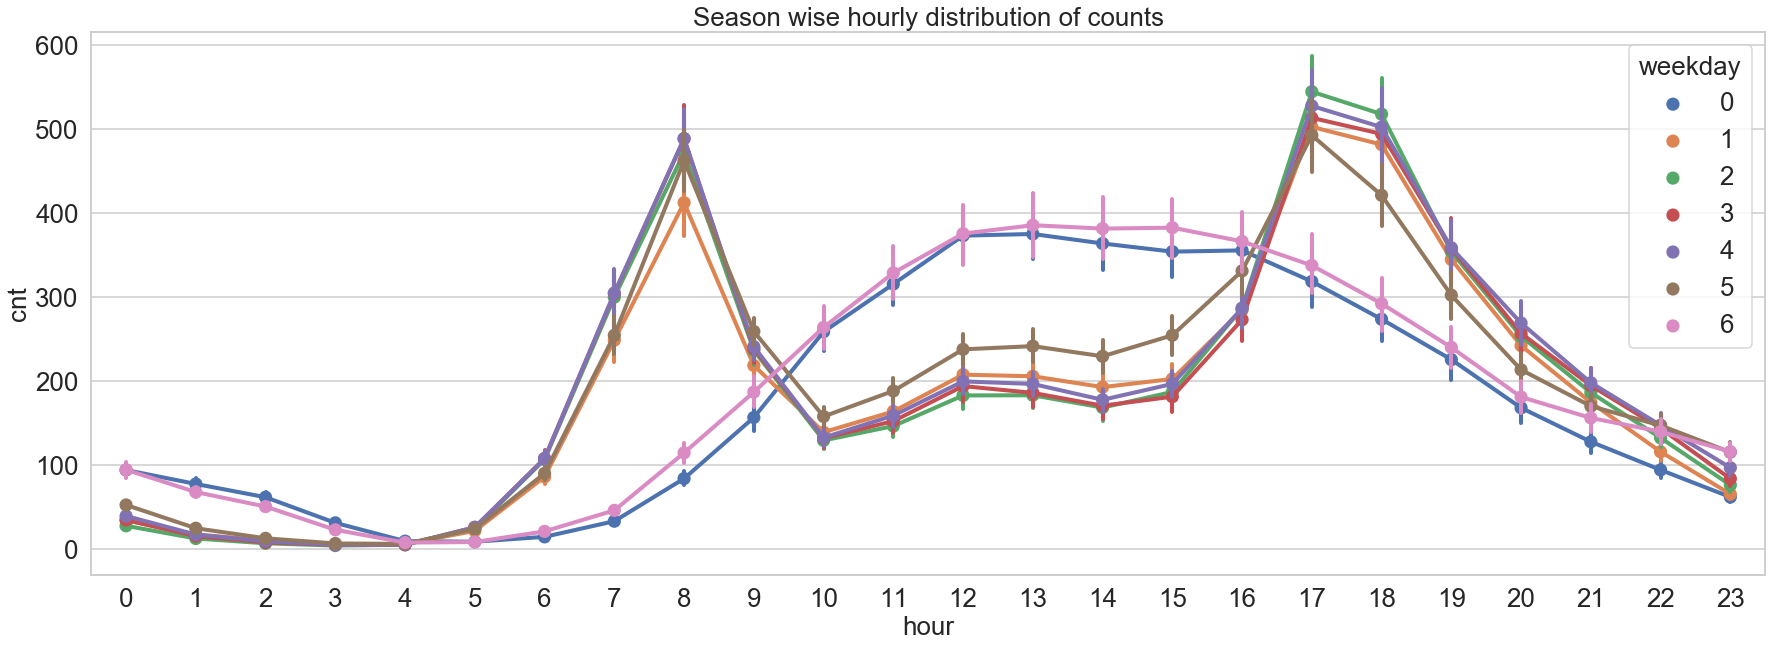

In [32]:
# Configuring plotting visual and sizes
sns.set_style("whitegrid")
sns.set_context("talk")
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (30, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}

plt.rcParams.update(params)
fig, ax = plt.subplots()
sns.pointplot(
    data=hour_df_out.compute()[["hour", "cnt", "weekday"]],
    x="hour",
    y="cnt",
    hue="weekday",
    ax=ax,
)
ax.set(title="Season wise hourly distribution of counts")

#### Average distribution whether holiday or not
People rent less during holidays and more during working days

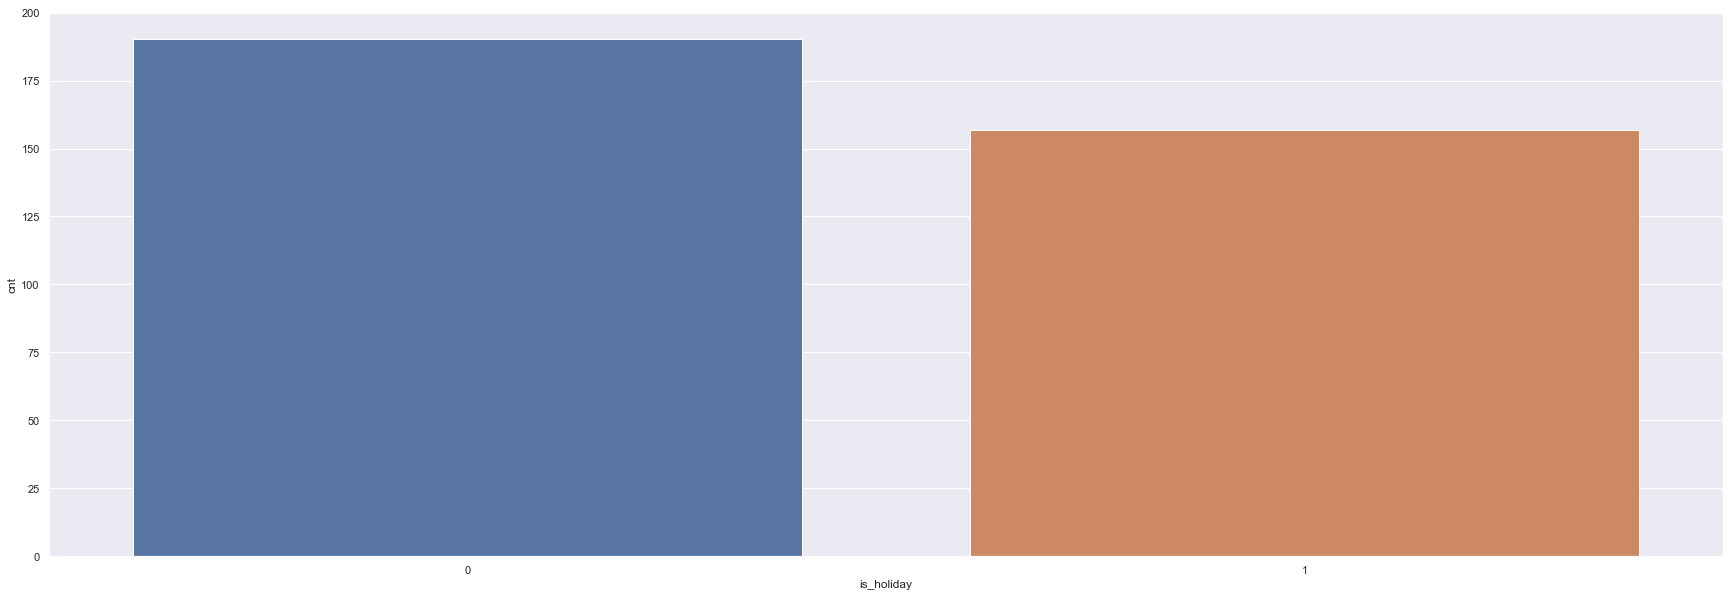

In [33]:
sns.set()
sns.barplot("is_holiday", "cnt", data=hour_df_out.compute(), ci=None)

#### Average distribution whether workday or not

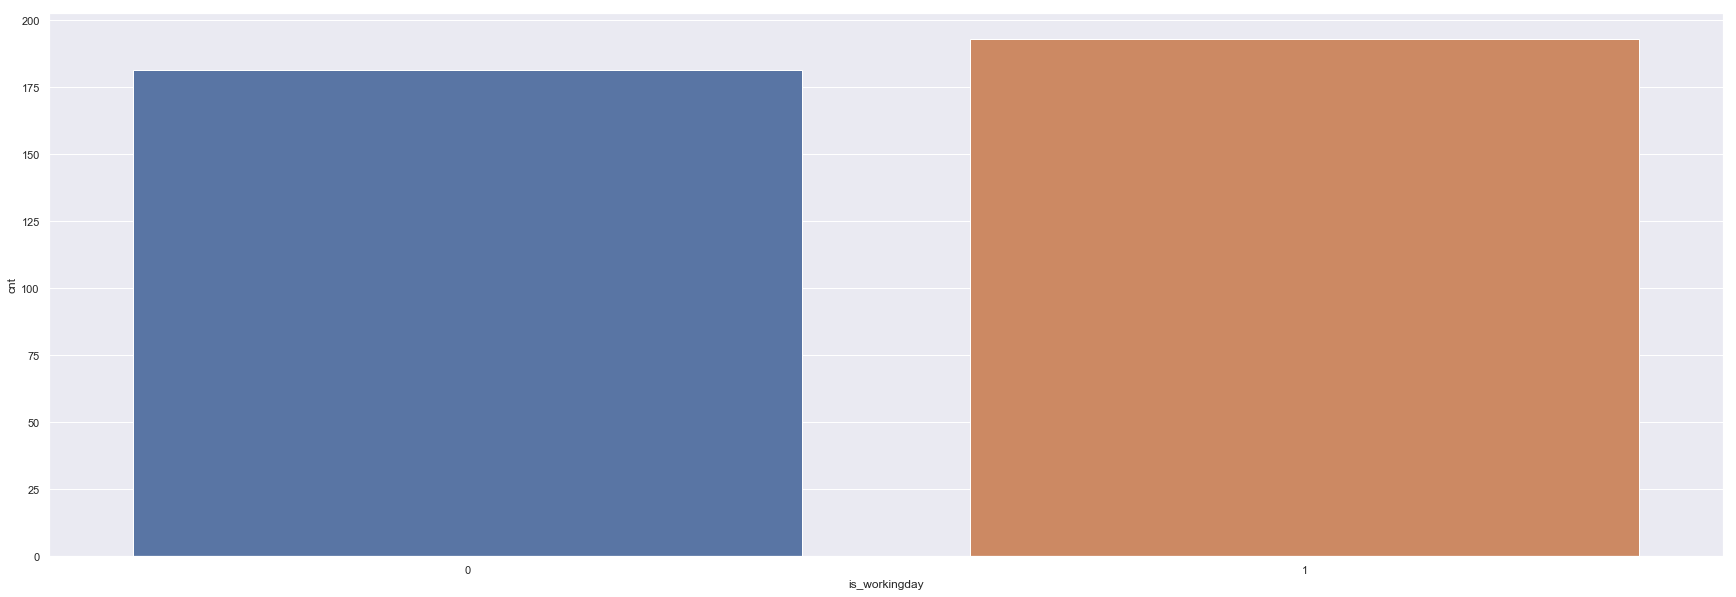

In [34]:
sns.set()
sns.barplot("is_workingday", "cnt", data=hour_df_out.compute(), ci=None)

### 1.5 Correlations
To understand how our variables are correlated to our target variable we will use visual representations. 

#### Correlation Heatmap
The correlation headmap below provides us with great insights on how each variable is correlated with the "cnt" variable.

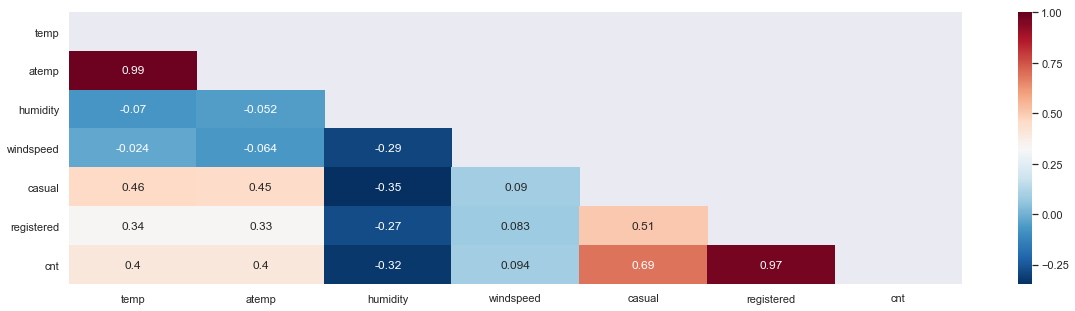

In [35]:
plt.figure(figsize=(20, 5))
mask = np.zeros_like(hour_df_out.compute().corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hour_df_out.compute().corr(), cmap="RdBu_r", mask=mask, annot=True)

#### Weather conditions

##### atemp
For the normalized feeling temperature "atemp" 0 is a low temperature while 1 is the maximum. We can see a peak in rentals as the weather gets warmer, then a decline towards the highest temperatures. 

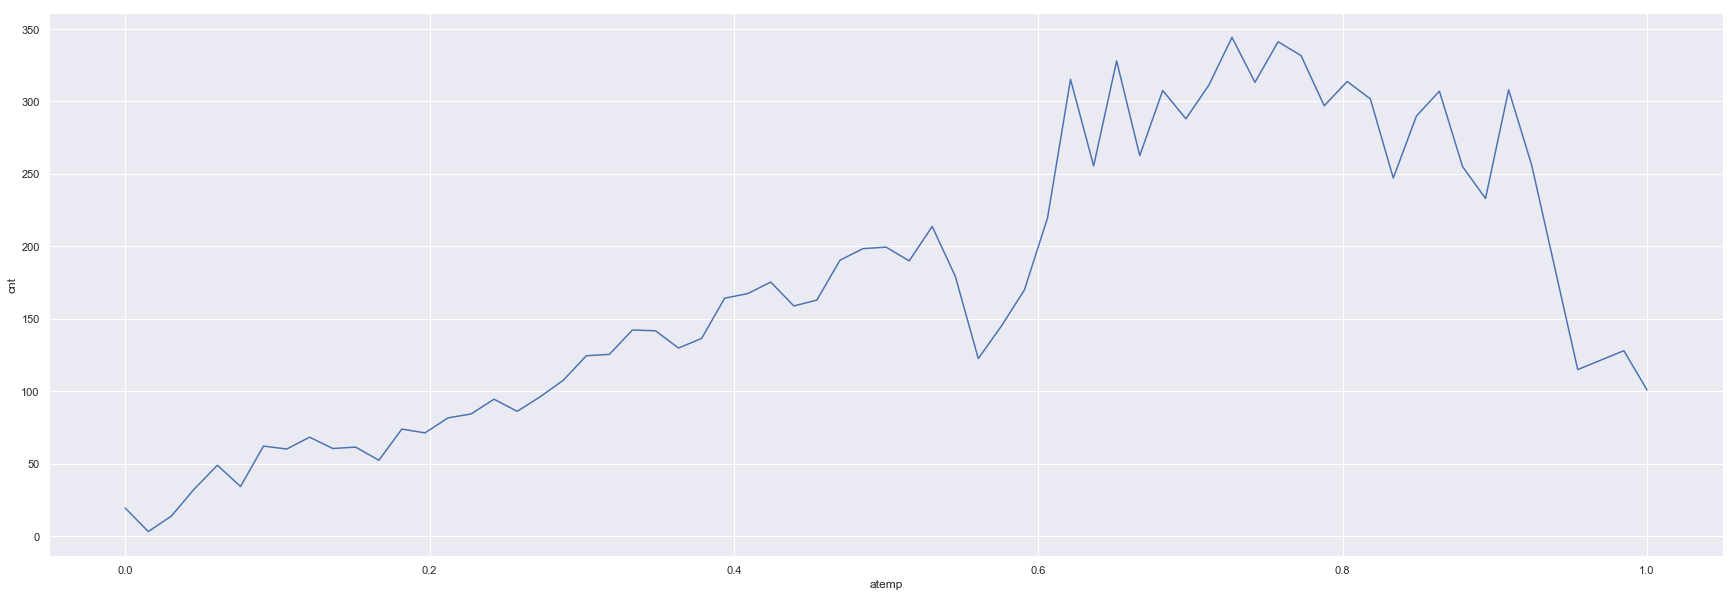

In [36]:
sns.set()
sns.lineplot("atemp", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

##### windspeed
In general, we observe that the higher the windseep the lower the number of bikes rented, except for a few peaks in high wind speed which could be explained by outliers (see the two barplots below with and without barplot). 
As we can see our outlier handling provides a more logical graph!

With outliers: 

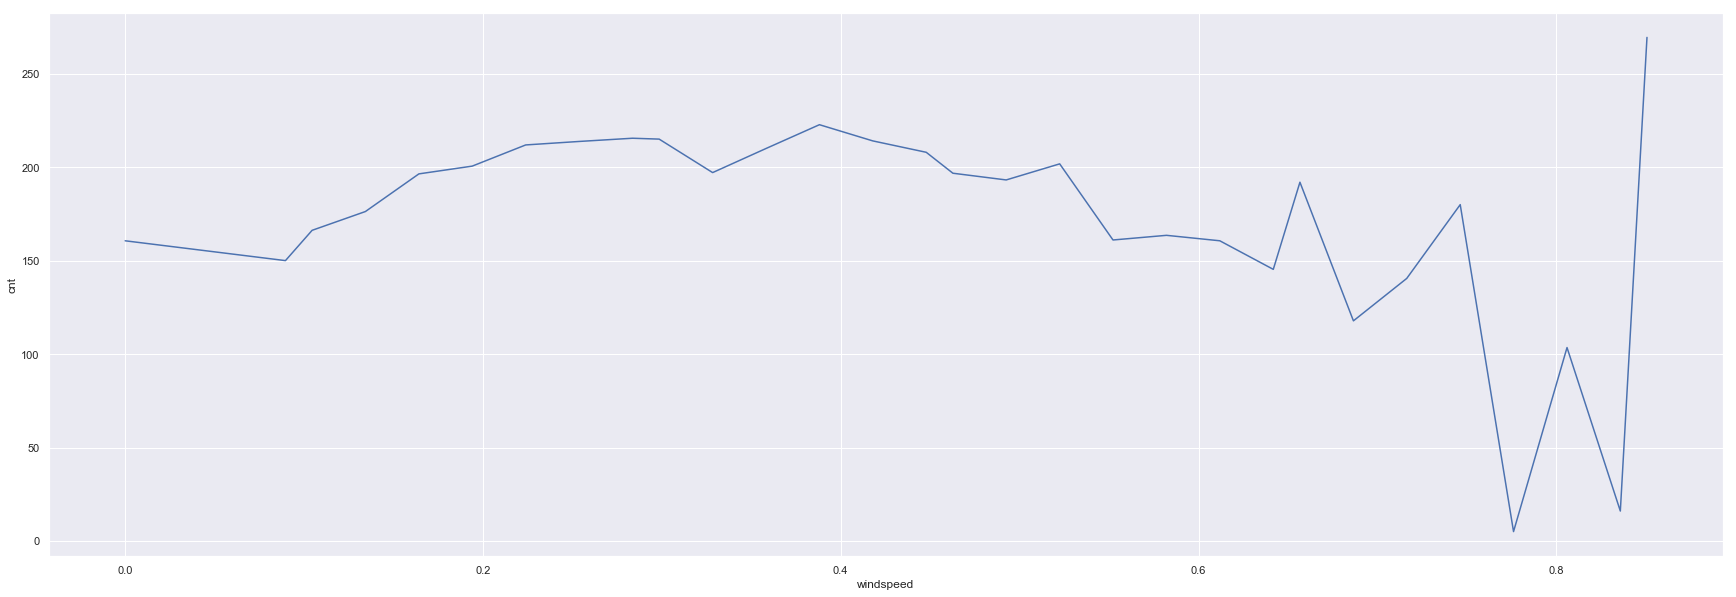

In [37]:
sns.set()
sns.lineplot("windspeed", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

Without outliers:

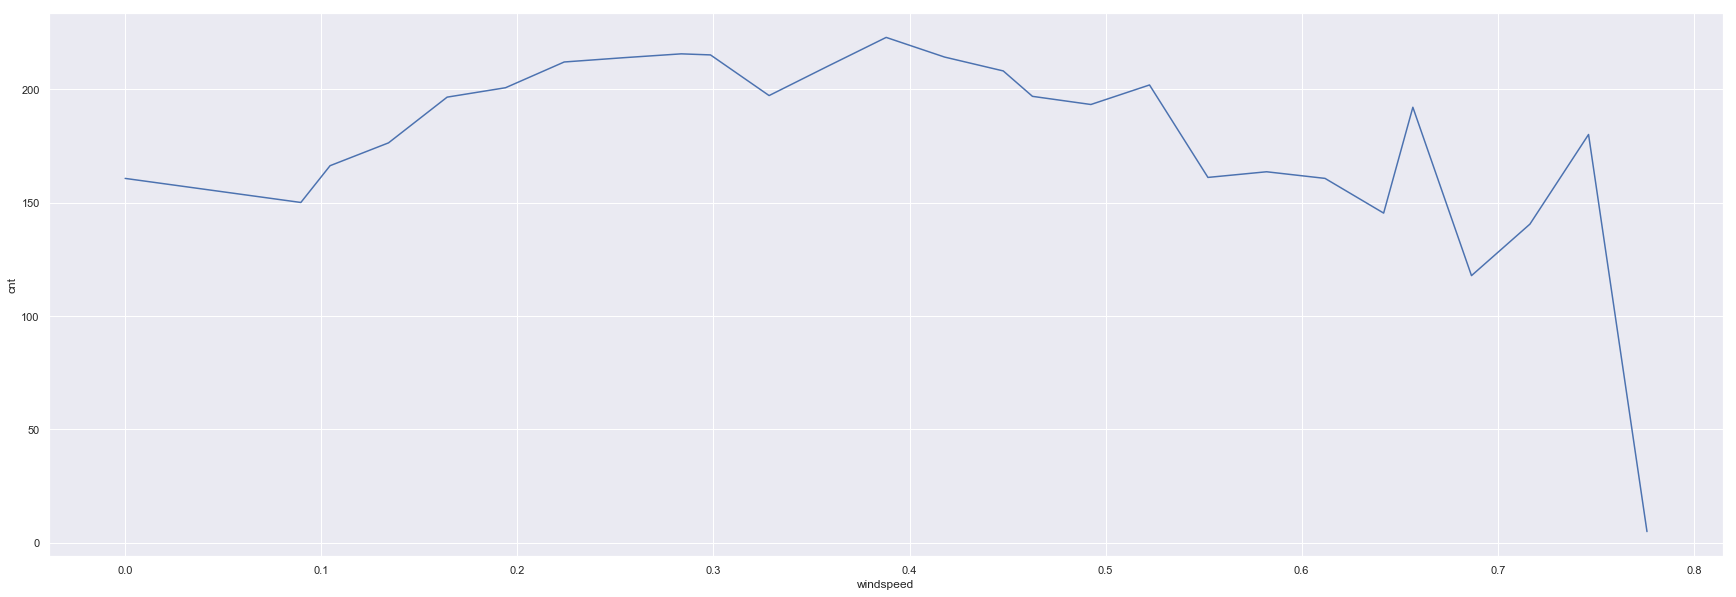

In [38]:
sns.set()
sns.lineplot("windspeed", "cnt", data=hour_df_out.compute(), palette="rainbow", ci=None)

##### weathersit
For the normalized weather situation "weathersit" 1 is considered the best weather situation, while 4 represents an extreme weather condition (natural disasters). Logically, as the weather condition worsens the rentals decrease.

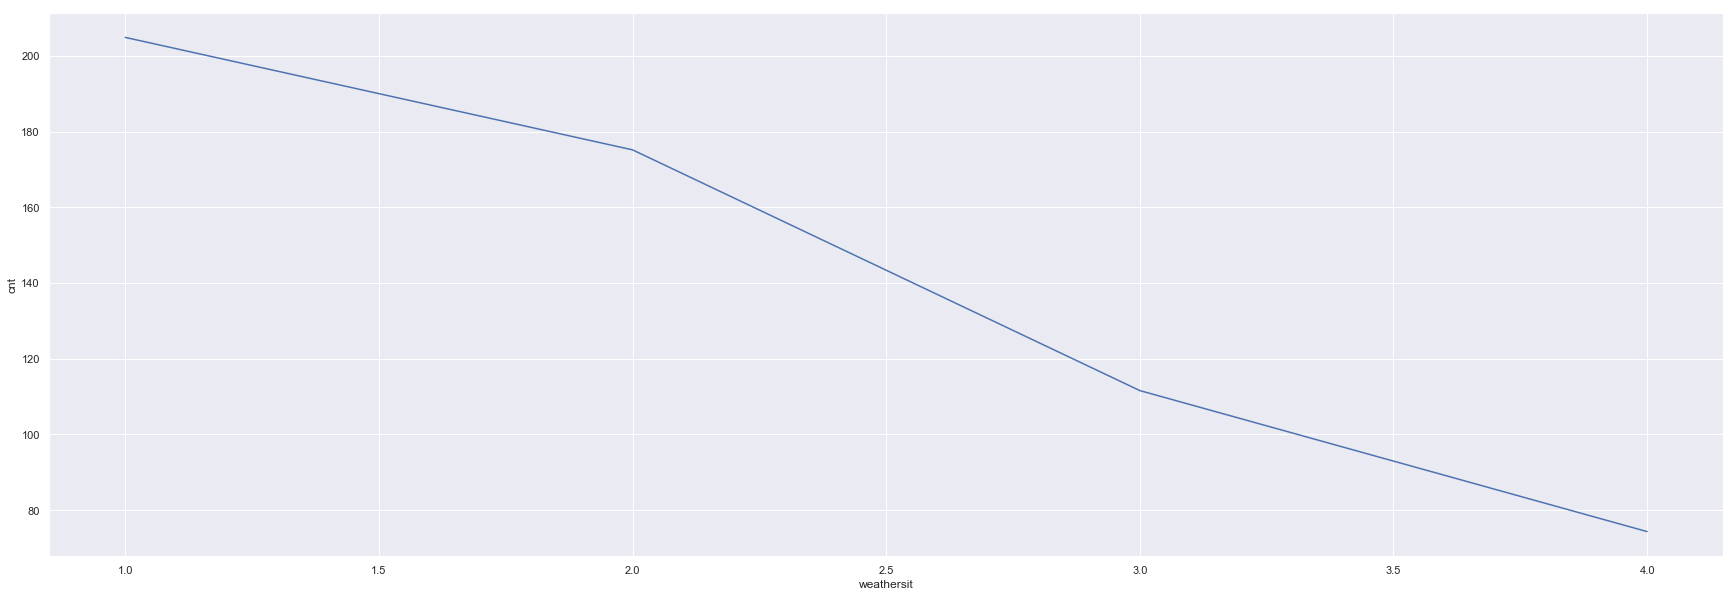

In [39]:
sns.set()
sns.lineplot("weathersit", "cnt", data=hour_df.compute(), palette="rainbow", ci=None)

## 2 Feature Engineering and Selection

### 2.1 Feature Creation

#### Heat Index

Normalized temperature can be used to calculate real temperature in Celcius which can be used to calculate the head index (HI) as well as wind chill index (WCI) which may or may not correlate with our target variable.

Given the equation used to normalize temperature, (t-t_min)/(t_max-t_min) where t_max is 39 and t_min is -8, we can derive the equation for temperature to be as follows:

temp_real = 47*temp - 8

In [40]:
# Calculate the real temperature using the above equation
hour_df_out["temp_real"] = 47 * hour_df_out["temp"] - 8

Using the results from real temperature in Celcius, we can use these values to calculate the heat index or humiture (HI), which is an index that combines air temperature and relative humidity. The formula used for calculation is as follows:
HI = c1 + c2T + c3R + c4TR + c5T^2 + c6R^2 + c7RT^2 + c8TR^2 + c9T^2R^2
where T is the temperature (in degrees Celcius) and R is the relative humidity (percentage value between 0 and 100)

c1 = −8.78469475556,
c2 = 1.61139411,
c3 = 2.33854883889,
c4 = -0.14611605,
c5 = -0.012308094,
c6 = -0.0164248277778,
c7 = 0.002211732,
c8 = 0.00072546,
c9 = -0.000003582,

In [41]:
hour_df_out["heat_index"] = (
    -8.78469475556
    + (1.61139411 * (hour_df_out["temp_real"]))
    + (2.33854883889 * hour_df_out["humidity"] * 100)
    + (-0.14611605 * hour_df_out["temp_real"] * hour_df_out["humidity"] * 100)
    + (-0.012308094 * (hour_df_out["temp_real"]) ** 2)
    + (-0.0164248277778 * (hour_df_out["humidity"] * 100) ** 2)
    + (
        0.002211732
        * ((hour_df_out["temp_real"]) ** 2)
        * (hour_df_out["humidity"] * 100)
    )
    + (0.00072546 * hour_df_out["temp_real"] * (hour_df_out["humidity"] * 100) ** 2)
    + (
        -0.000003582
        * ((hour_df_out["humidity"] * 100) * 2)
        * ((hour_df_out["temp_real"]) * 2)
    )
)

In [42]:
hour_df_out.head(1)

datetime season year month hour is_holiday weekday is_workingday  \
0 2011-01-01      1    0     1    0          0       6             0   

  weathersit  temp   atemp  humidity  windspeed  casual  registered  cnt  \
0          1  0.24  0.2879      0.81        0.0       3          13   16   

   temp_real  heat_index  
0       3.28   56.742832

#### Wind Chill Index (WCI)

We can also calculate the Wind Chill Index (WCI) which is the lowering of body temperature due to the passing-flow of lower-temperature air. 

The formula used is as follows:
WCI = (10*SQRT(windspeed) - windspeed + 10.5)*(33 - temp_real)

where:

WCI = wind chill index, kcal/m2/h
v = wind velocity, m/s
Ta = air temperature, °C

since our wind speed is in km/h we will use a 0.277778 coefficient to convert it to m/s

In [43]:
hour_df_out["WCI"] = (
    10 * da.sqrt(hour_df_out["windspeed"] * 0.277778 * 100)
    - (0.277778 * hour_df_out["windspeed"])
    + 10.5
) * (33 - hour_df_out["temp_real"])

#### Humidity Index (HX)

The humidex (“humidity Index”, abbreviated to HX in the present study) is a measure of the combined effect of heat and humidity on human physiology. It is calculated from air temperature and relative humidity. First, the vapour pressure of water v (in hPa) is calculated using:

v = (6.112 × 10ˆ(7.5*T/(237.7 + T)) * RH/100)

where T = air temperature (°C) and RH is the relative humidity (%). 

The Humidex (HX) is then found using:
HX = T + (v − 10) * 5 / 9

In [44]:
hour_df_out["v"] = (
    6.112 * 10 ** (7.5 * hour_df_out["temp_real"] / (237.7 + hour_df_out["temp_real"]))
) * (hour_df_out["humidity"])

hour_df_out["humidex"] = hour_df_out["temp_real"] + ((hour_df_out["v"] - 10) * (5 / 9))

Lets have a look at our correlation heatmap again:

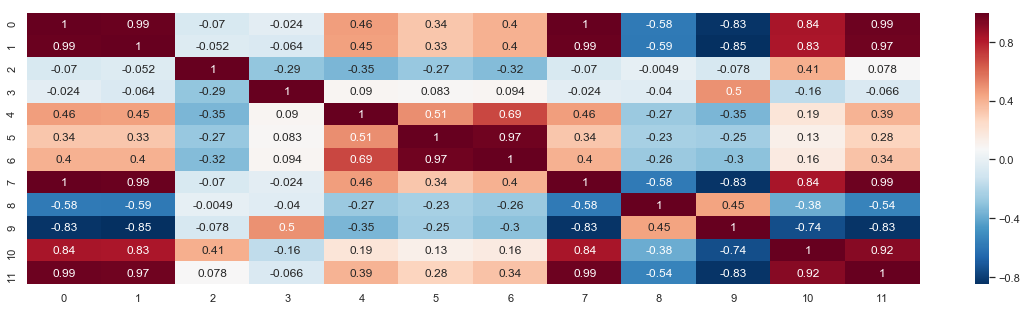

In [45]:
# check correlations again
# Based on this we identified multicollinearity between season and month and decided to drop month as season has a higher correlation with the target variable cnt
plt.figure(figsize=(20, 5))
mask = np.zeros_like(hour_df_out.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(hour_df_out.corr(), cmap="RdBu_r", annot=True)

And here to see the first row of our dataset:

In [46]:
hour_df_out.head(1)

datetime season year month hour is_holiday weekday is_workingday  \
0 2011-01-01      1    0     1    0          0       6             0   

  weathersit  temp    ...     humidity  windspeed  casual  registered  cnt  \
0          1  0.24    ...         0.81        0.0       3          13   16   

   temp_real  heat_index     WCI         v   humidex  
0       3.28   56.742832  312.06  6.262555  1.203641  

[1 rows x 21 columns]

### 2.2 Feature Selection

Based on the following graphs and the heatmap above we perform our feature selection.

#### temp

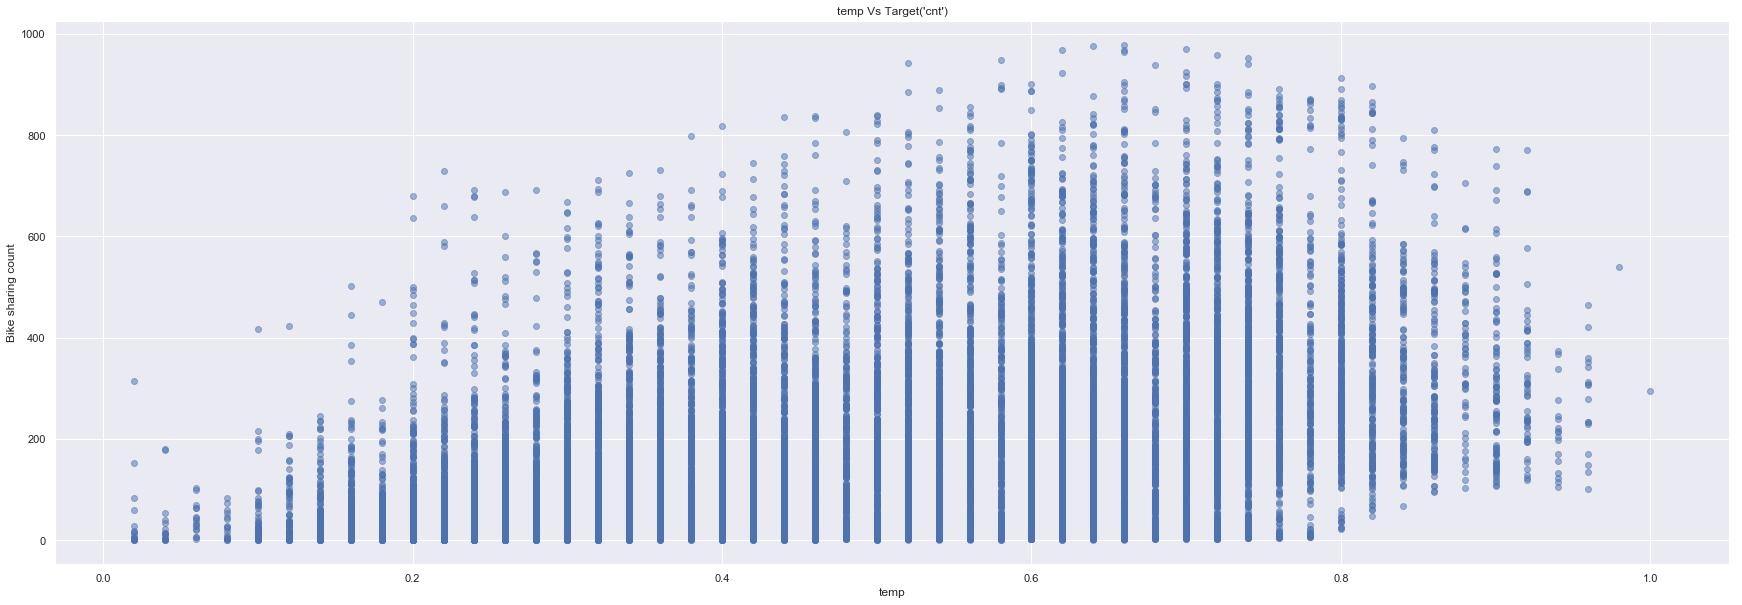

In [47]:
# temp vs Target
plt.scatter(hour_df_out.compute()[['temp']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("temp Vs Target('cnt')")
plt.xlabel("temp")
plt.ylabel("Bike sharing count")
plt.show()

#### atemp

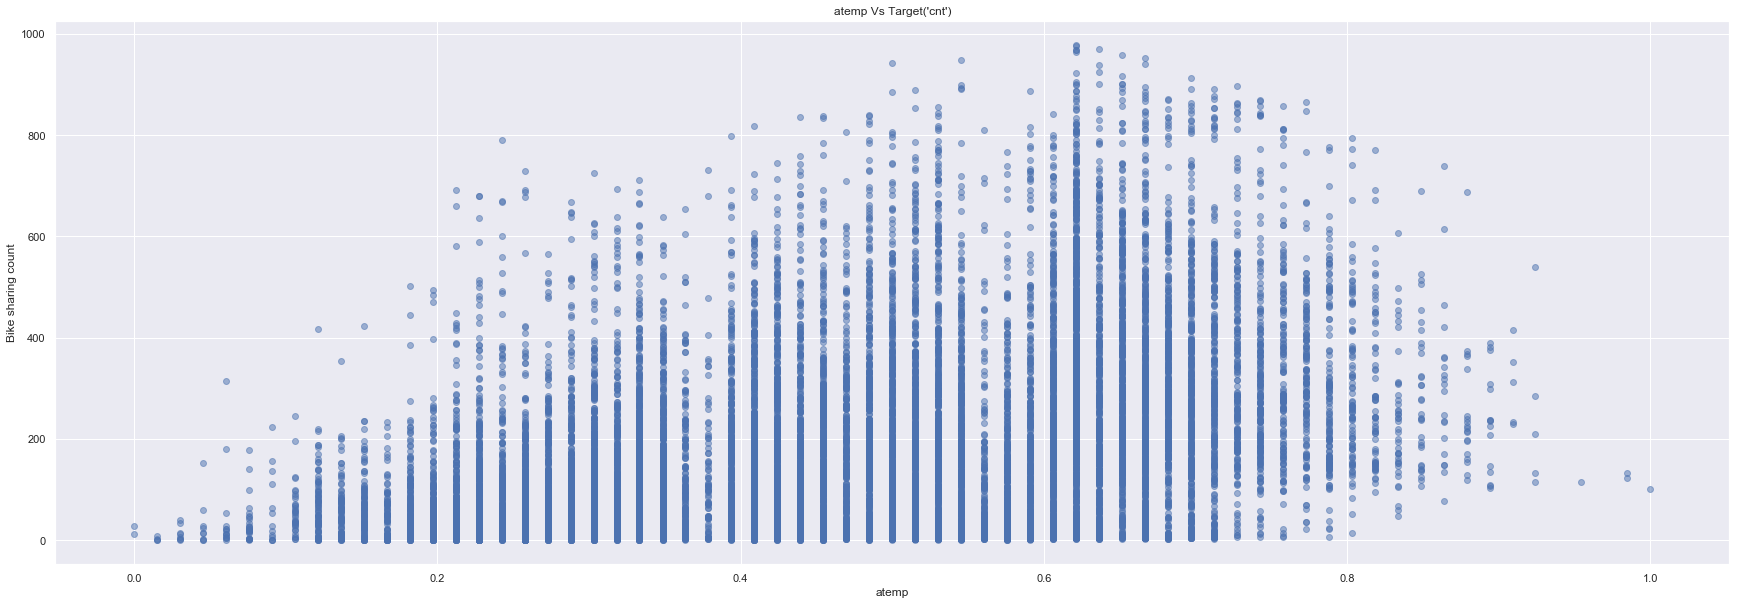

In [48]:
# atemp vs Target
plt.scatter(hour_df_out.compute()[['atemp']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("atemp Vs Target('cnt')")
plt.xlabel("atemp")
plt.ylabel("Bike sharing count")
plt.show()

#### humidity

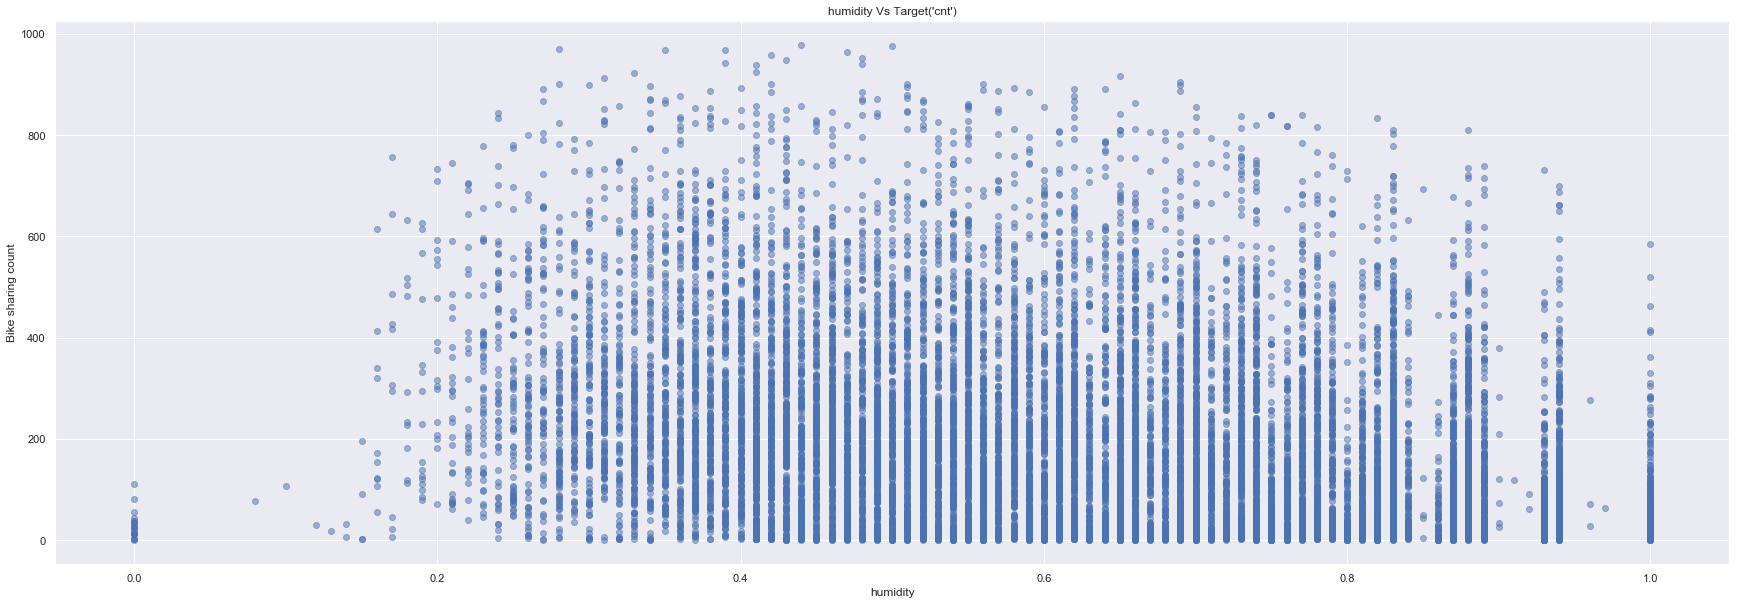

In [49]:
# temp vs Target
plt.scatter(hour_df_out.compute()[['humidity']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("humidity Vs Target('cnt')")
plt.xlabel("humidity")
plt.ylabel("Bike sharing count")
plt.show()

#### windspeed

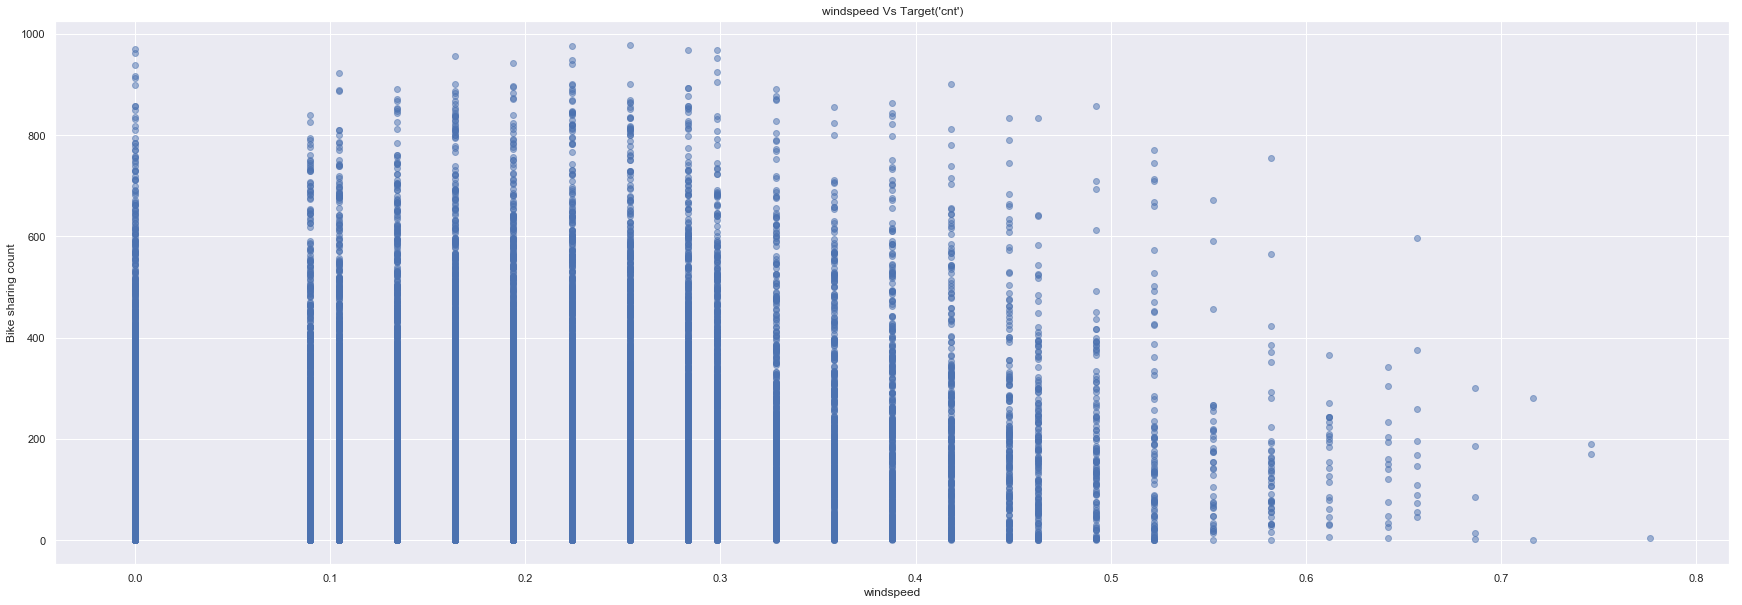

In [50]:
# windspeed vs Target
plt.scatter(hour_df_out.compute()[['windspeed']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("windspeed Vs Target('cnt')")
plt.xlabel("windspeed")
plt.ylabel("Bike sharing count")
plt.show()

#### casual

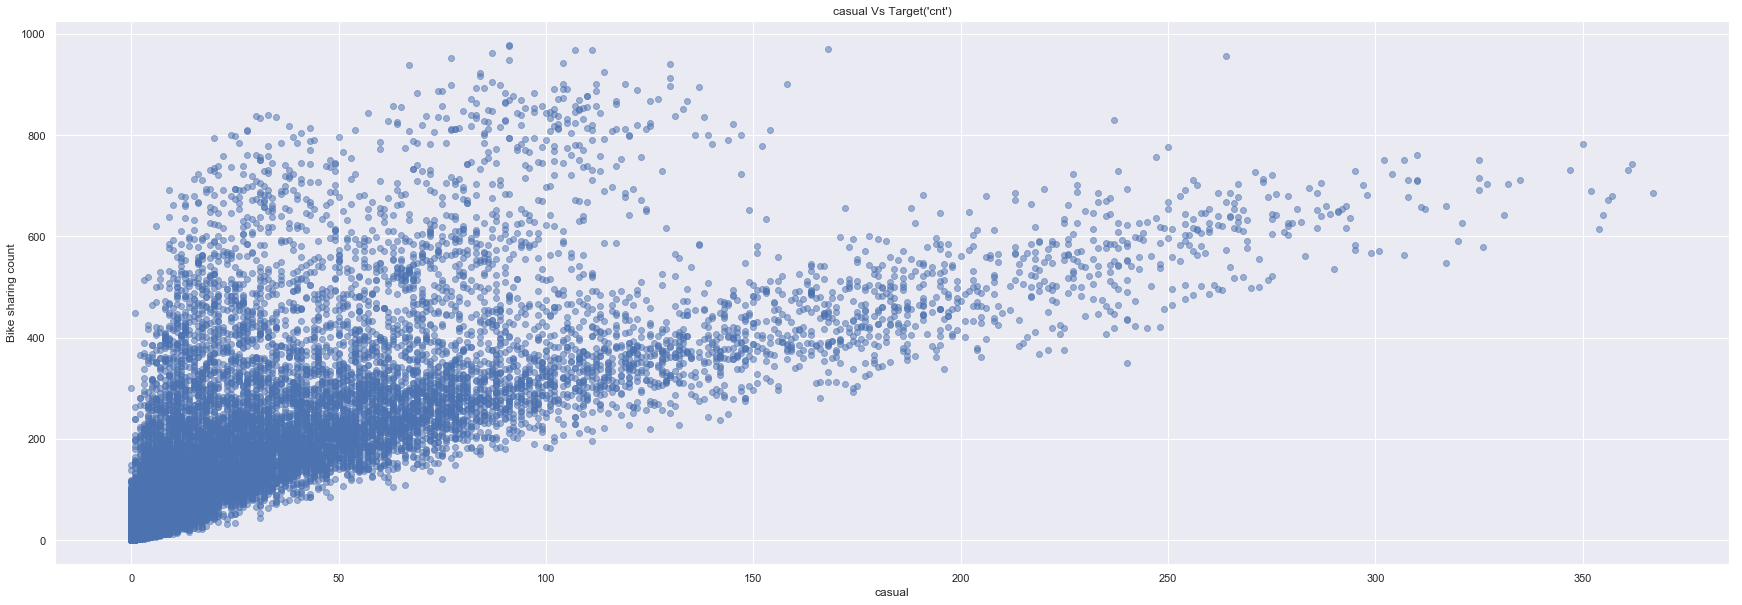

In [51]:
# casual vs Target
plt.scatter(hour_df_out.compute()[['casual']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("casual Vs Target('cnt')")
plt.xlabel("casual")
plt.ylabel("Bike sharing count")
plt.show()

#### registered

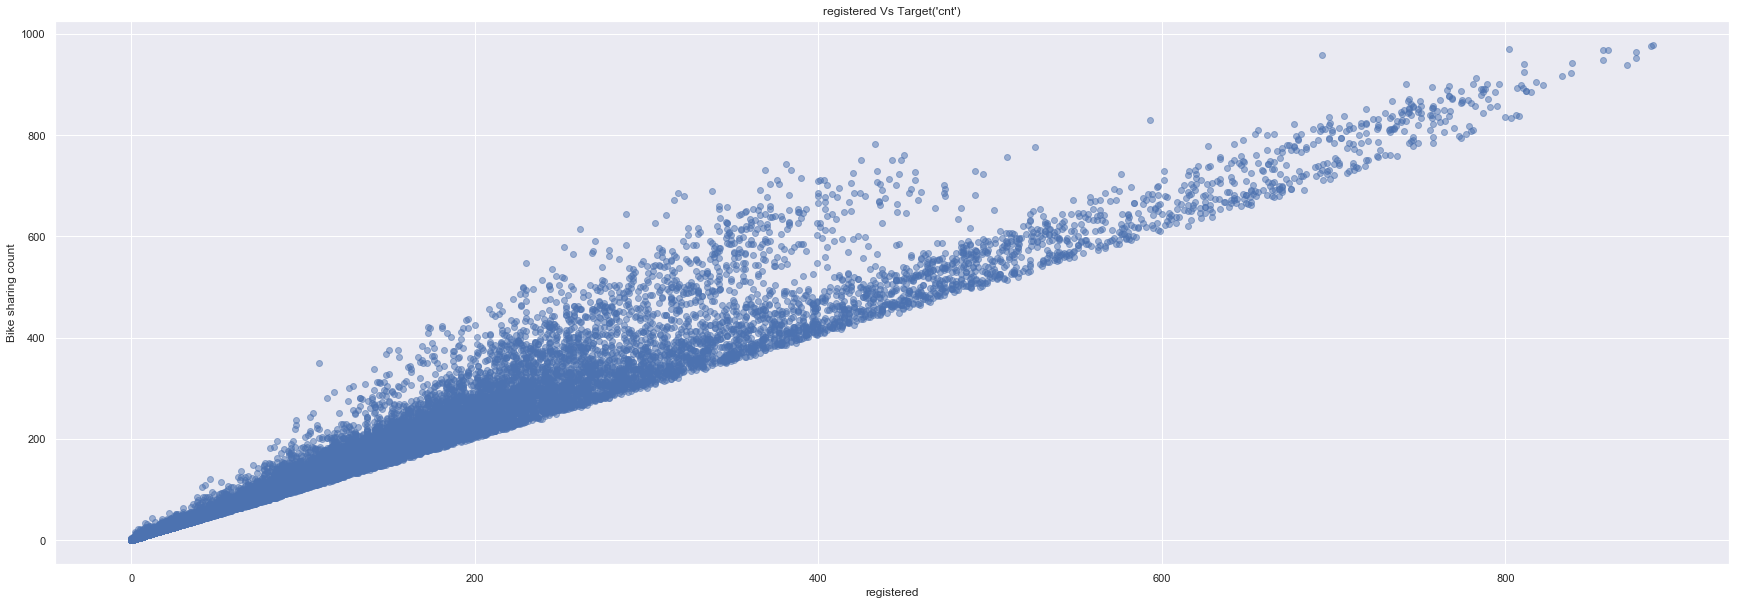

In [52]:
# registered vs Target
plt.scatter(hour_df_out.compute()[['registered']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("registered Vs Target('cnt')")
plt.xlabel("registered")
plt.ylabel("Bike sharing count")
plt.show()

#### temp_real

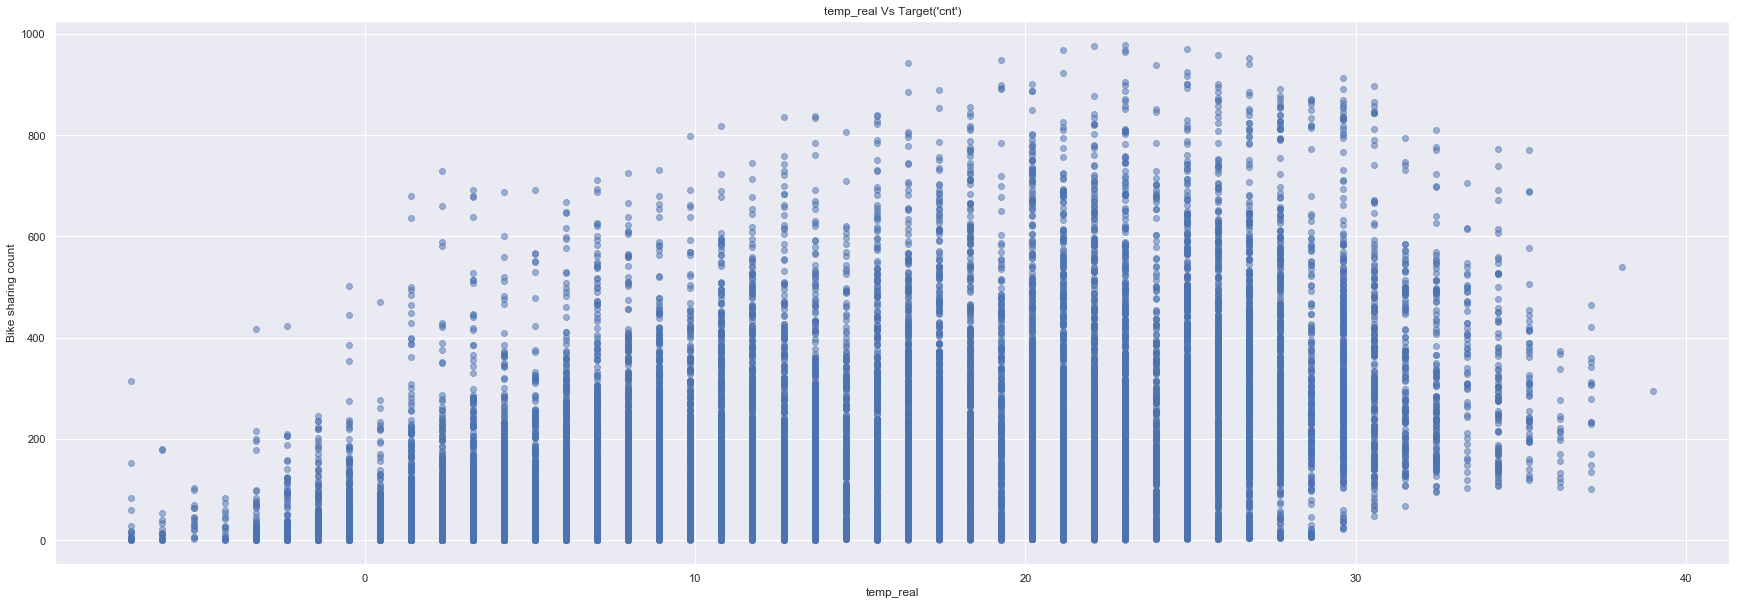

In [53]:
# temp_real vs Target
plt.scatter(hour_df_out.compute()[['temp_real']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("temp_real Vs Target('cnt')")
plt.xlabel("temp_real")
plt.ylabel("Bike sharing count")
plt.show()

#### heat_index

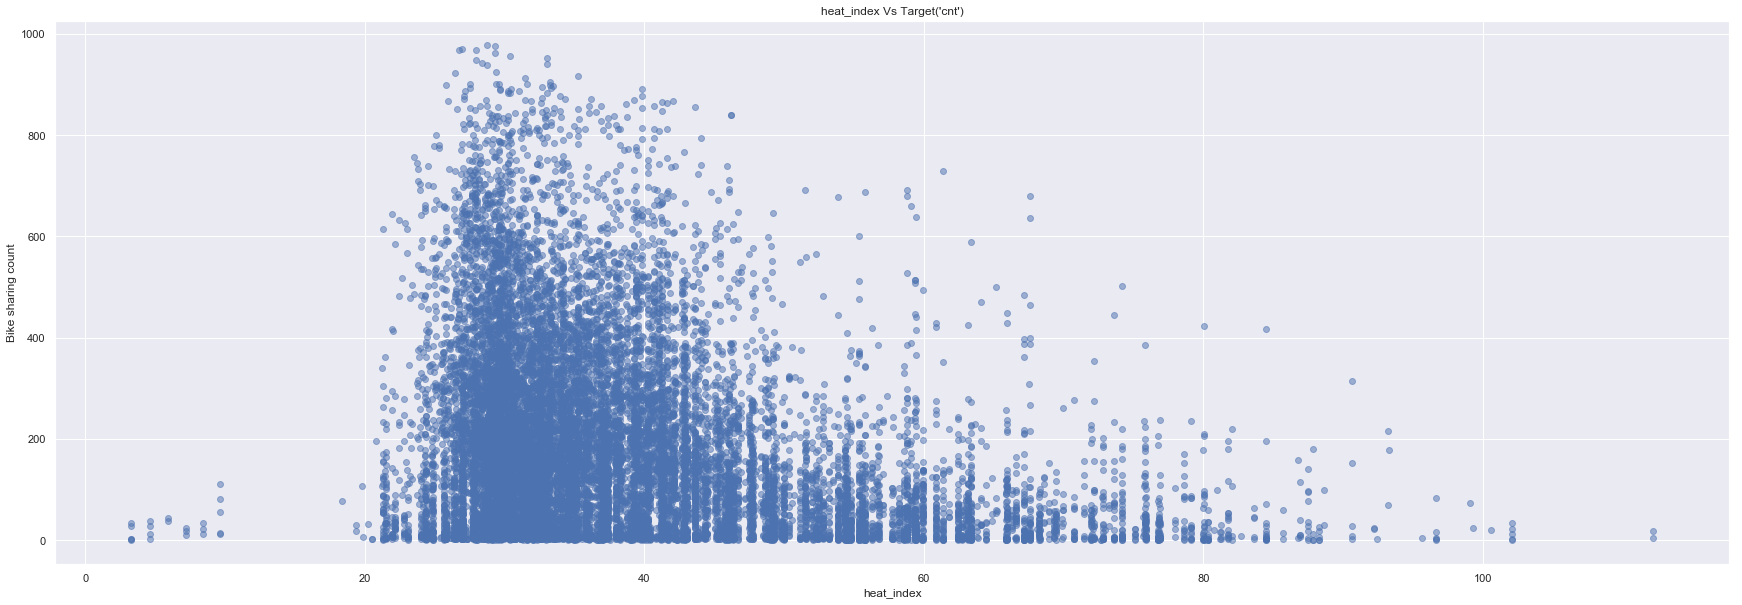

In [54]:
# heat_index vs Target
plt.scatter(hour_df_out.compute()[['heat_index']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("heat_index Vs Target('cnt')")
plt.xlabel("heat_index")
plt.ylabel("Bike sharing count")
plt.show()

#### WCI

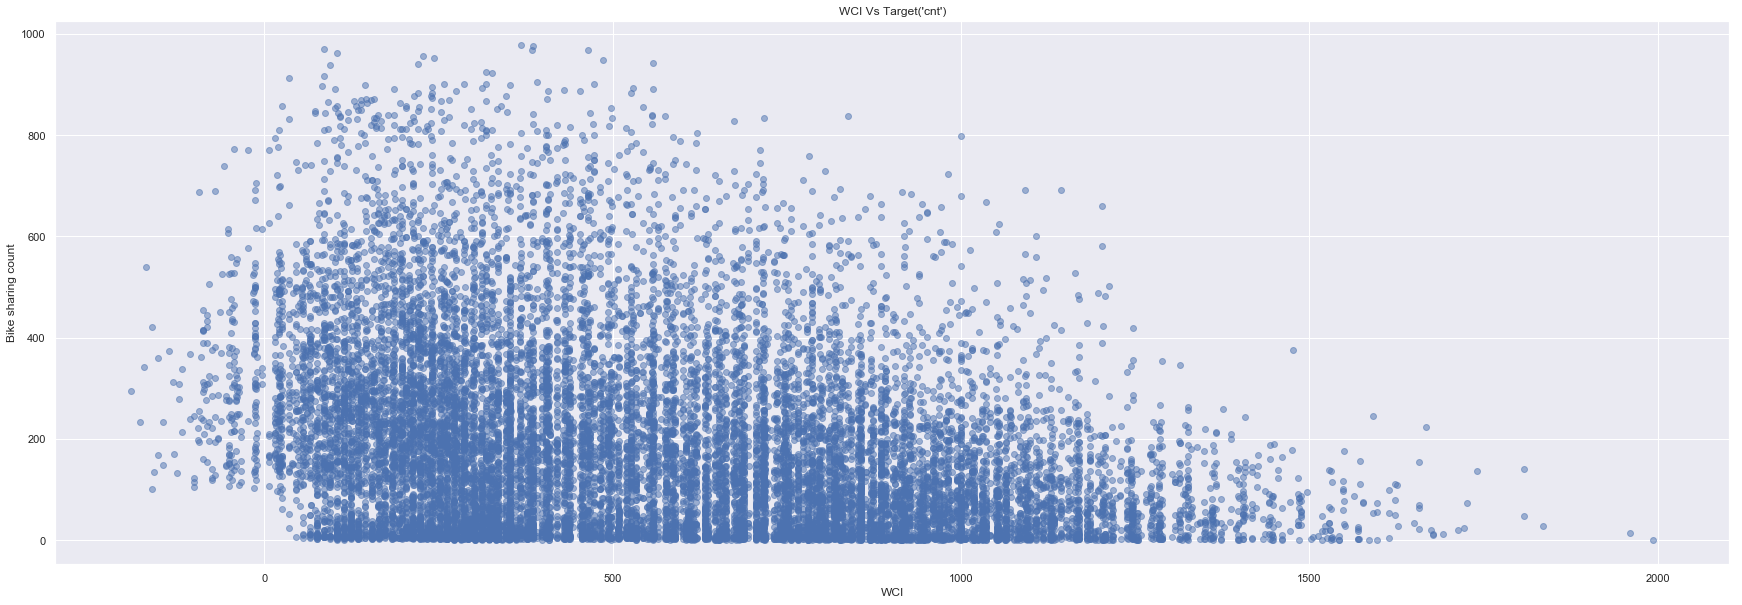

In [55]:
# WCI vs Target
plt.scatter(hour_df_out.compute()[['WCI']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("WCI Vs Target('cnt')")
plt.xlabel("WCI")
plt.ylabel("Bike sharing count")
plt.show()

#### v

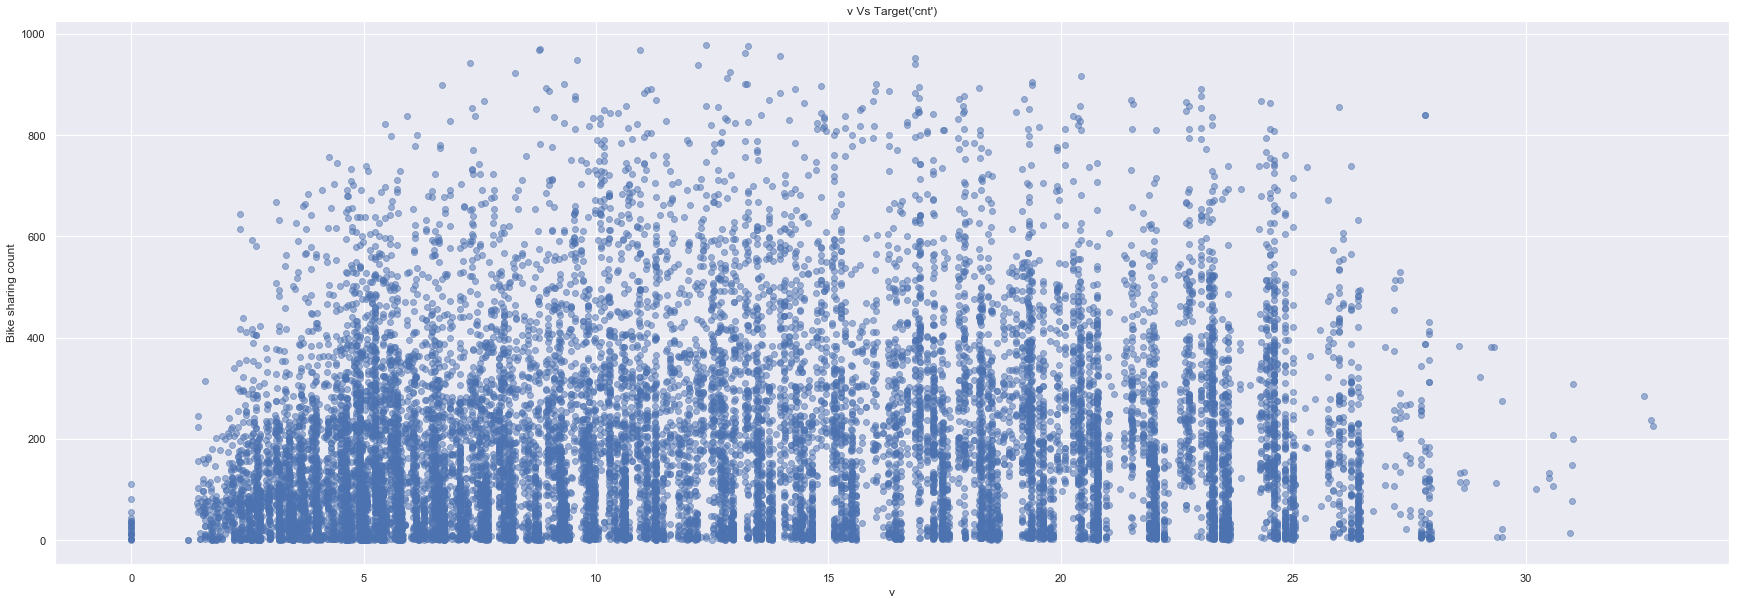

In [56]:
# WCI vs Target
plt.scatter(hour_df_out.compute()[['v']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("v Vs Target('cnt')")
plt.xlabel("v")
plt.ylabel("Bike sharing count")
plt.show()

#### humidex

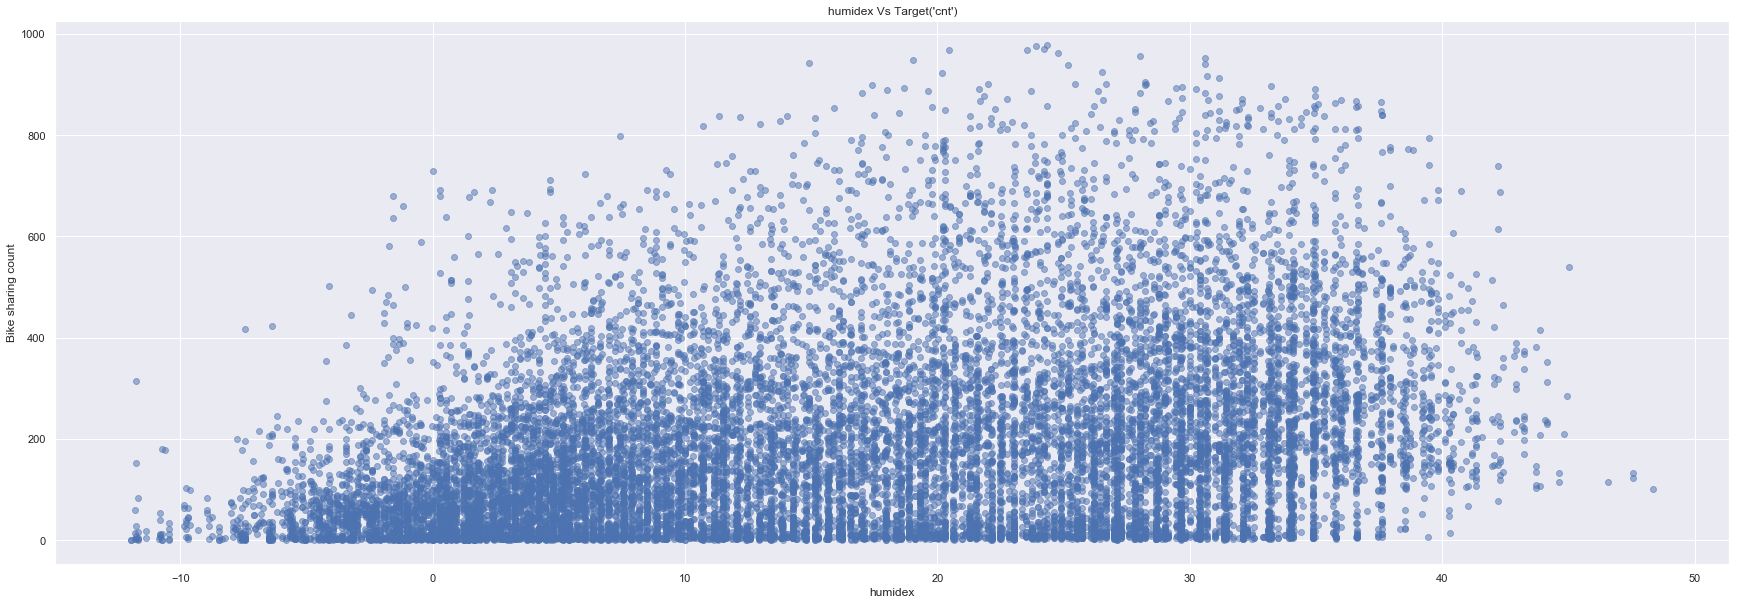

In [57]:
# WCI vs Target
plt.scatter(hour_df_out.compute()[['humidex']], hour_df_out.compute()[['cnt']], alpha=0.5)
plt.title("humidex Vs Target('cnt')")
plt.xlabel("humidex")
plt.ylabel("Bike sharing count")
plt.show()

### Conclusion
Based on visual representation of the correlation of each variable (see for all varibles below) and the heatmap above, we will decide which variables we will exclude in order to avoid multicolliniarity. As a result of this inspection we decide **not to use** the following variables to train and predict:
- "cnt" (target variable)
- "registered" (too highly correlated with target variable)
- "casual" (too highly correlated with target variable)
- "atemp" (too highly correlated with target "temp" and "humidex")
- "windspeed" (too low correlated with target variable)

## 3 Basic Models

Initially we import a few libraries we need:

In [61]:
from sklearn import linear_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import datetime as dt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.externals.joblib import parallel_backend

### 3.1 Linear Reg Trial on Original Dataset hour_df / Baseline Model
First we will try with a simple regression model with our original dataset to get a benchmark score. That means that we will use the dataset as **it was imported** just to get a first benchmark for our future modeling. 

To improve the performance during modeling, the option to "Parallelize Scikit-Learn Directly" found at https://ml.dask.org was used.

In [62]:
lr_model = linear_model.LinearRegression()

traintrial = hour_df[hour_df["datetime"] < "2012-10-01"]
testtrial = hour_df[hour_df["datetime"] >= "2012-10-01"]

# drop the target variable and "registered" variable since we are using registered along with the rest of features.
X_traintrial = traintrial.drop(["cnt", "registered", "month", "casual"], axis=1)
y_traintrial = traintrial["cnt"]
X_testtrial = testtrial.drop(["cnt", "registered", "month","casual"], axis=1)
y_testtrial = testtrial["cnt"]
X_traintrial = X_traintrial.drop(["datetime"], axis=1)
X_testtrial = X_testtrial.drop(["datetime"], axis=1)

In [63]:
with parallel_backend('dask'):

    lr_model.fit(X_traintrial, y_traintrial)
    # making predection using the test set
    y_predtrial = lr_model.predict(X_testtrial)
    y_predtrial = [
        i if i >= 0 else 0 for i in y_predtrial
    ]  # in case a value is predicted as minus

print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_testtrial, y_predtrial)))
print("R2: %.2F" % r2_score(y_testtrial, y_predtrial))


RMSE: 167.55
R2: 0.31


Therefore our baseline score for RMSE with the original dataset is 169.23 and R2 of 0.3

### 3.2 Linear Reg Trial on prepared Dataset
As seen in the sections above we have removed outliers and done feature creation. Now we will try how this effects our simple linear regression.

In [64]:
hour_df_out_copy = hour_df_out

split_date = dt.date(2012, 9, 30)

train_base = hour_df_out_copy[hour_df_out_copy["datetime"] < "2012-10-01"]
test_base = hour_df_out_copy[hour_df_out_copy["datetime"] >= "2012-10-01"]

# drop the target variable and "registered" variable since we are using registered along with the rest of features.
# drop atemp and windspeed for low correlation with the target variable
X_train_base = train_base.drop(
    ["cnt", "registered", "casual", "atemp","month", "windspeed"], axis=1
)
y_train_base = train_base["cnt"]

X_test_base = test_base.drop(
    ["cnt", "registered", "casual","month", "atemp", "windspeed"], axis=1
)
y_test_base = test_base["cnt"]

X_train_base = X_train_base.drop(["datetime"], axis=1)
X_test_base = X_test_base.drop(["datetime"], axis=1)

In [65]:
with parallel_backend('dask'):
    lr_model.fit(X_train_base, y_train_base)

    # making predection using the test set
    y_pred_base = lr_model.predict(X_test_base)

    y_pred_base = [
        i if i >= 0 else 0 for i in y_pred_base
    ]  # in case a value is predicted as minus


In [66]:
# root mean squared error
print("Base RMSE: %.2f" % math.sqrt(mean_squared_error(y_test_base, y_pred_base)))
print("R2: %.2F" % r2_score(y_test_base, y_pred_base))

Base RMSE: 168.18
R2: 0.30


After removing outliers, our base RMSE has changed from 169.78 to 169.23 and R2 is 0.29, similar to the previous model with outliers.

### Brief digression: PCA
As we have seen in the heatmap we do not have that much correlation within the variables and therefore expect PCA to not perform good. The PCA uses the information contained in the mutual correlations between variables to identify those that are redundant.

In [67]:
from sklearn.decomposition import PCA

with parallel_backend('dask'):
    pca = PCA(11)
    X_train_PCA = pca.fit_transform(X_train_base)
    X_test_PCA = pca.transform(X_test_base)

print(pca.explained_variance_)

with joblib.parallel_backend('dask'):
    X_train_PCA = pca.fit_transform(X_train_base)
    X_test_PCA = pca.transform(X_test_base)

[1.21447035e+05 1.29693928e+02 6.60447167e+01 4.77068414e+01
 8.40501308e+00 4.00884044e+00 8.23331425e-01 3.42158681e-01
 2.16412096e-01 2.10096592e-01 2.39141786e-02]


In [69]:
with parallel_backend('dask'):
    # fitting linear model with PCA
    lr_model.fit(X_train_PCA, y_train_base)

    # making predection using the test set
    y_pred_PCA = lr_model.predict(X_test_PCA)


In [70]:
# root mean squared error
print("Base RMSE: %.2f" % math.sqrt(mean_squared_error(y_test_base, y_pred_PCA)))
print("R2: %.2F" % r2_score(y_test_base, y_pred_PCA))

Base RMSE: 167.96
R2: 0.31


### 3.3 One hot encoding
We can now use one hot encoding for categorical variables. This will help our models to interpret the influence of categorical features.

In [71]:
hour_df_out.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17374 entries, 0 to 17378
Data columns (total 21 columns):
datetime         17374 non-null datetime64[ns]
season           17374 non-null category
year             17374 non-null category
month            17374 non-null category
hour             17374 non-null category
is_holiday       17374 non-null category
weekday          17374 non-null category
is_workingday    17374 non-null category
weathersit       17374 non-null category
temp             17374 non-null float64
atemp            17374 non-null float64
humidity         17374 non-null float64
windspeed        17374 non-null float64
casual           17374 non-null int64
registered       17374 non-null int64
cnt              17374 non-null int64
temp_real        17374 non-null float64
heat_index       17374 non-null float64
WCI              17374 non-null float64
v                17374 non-null float64
humidex          17374 non-null float64
dtypes: category(8), datetime64[ns](1), fl

In [72]:
hour_df_out = hour_df_out.categorize()

In [73]:
def generate_dummies(df, dummy_column):
    """Function to create dummified features out of categorical features"""
    dummies = dd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = dd.concat([df, dummies], axis=1)
    return df


hour_dummified = hour_df_out
dummy_columns = [
    "season",
    "month",
    "year",
    "hour",
    "weekday",
    "weathersit",
    "is_workingday",
    "is_holiday",
]

with parallel_backend('dask'):
    for dummy_column in dummy_columns:
        hour_dummified = generate_dummies(hour_dummified, dummy_column)

/anaconda3/lib/python3.7/site-packages/dask/dataframe/multi.py:608: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn("Concatenating dataframes with unknown divisions.\n"
/anaconda3/lib/python3.7/site-packages/dask/dataframe/multi.py:608: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn("Concatenating dataframes with unknown divisions.\n"
/anaconda3/lib/python3.7/site-packages/dask/dataframe/multi.py:608: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn("Concatenating dataframes with unknown divisions.\n"
/anaconda3/lib/python3.7/site-packages/dask/dataframe/multi.py:608: UserWarning: Concate

In [74]:
# remove the original categorical variables: "season", "yr", "mnth", "hr", "weekday", "weathersit"
with parallel_backend('dask'):
    for dummy_column in dummy_columns:
        del hour_dummified[dummy_column]

Lets have short look at our dummified dataset:

In [75]:
hour_dummified.head(5)

datetime  temp   atemp  humidity  windspeed  casual  registered  cnt  \
0 2011-01-01  0.24  0.2879      0.81        0.0       3          13   16   
1 2011-01-01  0.22  0.2727      0.80        0.0       8          32   40   
2 2011-01-01  0.22  0.2727      0.80        0.0       5          27   32   
3 2011-01-01  0.24  0.2879      0.75        0.0       3          10   13   
4 2011-01-01  0.24  0.2879      0.75        0.0       0           1    1   

   temp_real  heat_index      ...       weekday_5  weekday_6  weathersit_1  \
0       3.28   56.742832      ...               0          1             1   
1       2.34   61.361310      ...               0          1             1   
2       2.34   61.361310      ...               0          1             1   
3       3.28   58.591036      ...               0          1             1   
4       3.28   58.591036      ...               0          1             1   

   weathersit_2  weathersit_3  weathersit_4  is_workingday_0  is_workingday_1  \
0             0             0             0                1                0   
1             0             0             0                1                0   
2             0             0             0                1                0   
3             0             0             0                1                0   
4             0             0             0                1                0   

   is_holiday_0  is_holiday_1  
0             1             0  
1             1             0  
2             1             0  
3             1             0  
4             1             0  

[5 rows x 70 columns]

The full list of variables after dummifying:

In [76]:
list(hour_dummified.columns)

['datetime',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'cnt',
 'temp_real',
 'heat_index',
 'WCI',
 'v',
 'humidex',
 'season_1',
 'season_2',
 'season_3',
 'season_4',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11',
 'month_12',
 'year_0',
 'year_1',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'weathersit_1',
 'weathersit_2',
 'weathersit_3',
 'weathersit_4',
 'is_workingday_0',
 'is_workingday_1',
 'is_holiday_0',
 'is_holiday_1']

### 3.4 Split Dummified Dataset
Now splitting the dataset after one hot encoding and trying the same model to check for improvement. **From now on this dataset serves as basis for all our models and predictions.**

In [77]:
split_date = dt.date(2012, 9, 30)
train = hour_dummified[hour_dummified["datetime"] < "2012-10-01"]
train.compute().shape

(15206, 70)

In [78]:
train.head()

datetime  temp   atemp  humidity  windspeed  casual  registered  cnt  \
0 2011-01-01  0.24  0.2879      0.81        0.0       3          13   16   
1 2011-01-01  0.22  0.2727      0.80        0.0       8          32   40   
2 2011-01-01  0.22  0.2727      0.80        0.0       5          27   32   
3 2011-01-01  0.24  0.2879      0.75        0.0       3          10   13   
4 2011-01-01  0.24  0.2879      0.75        0.0       0           1    1   

   temp_real  heat_index      ...       weekday_5  weekday_6  weathersit_1  \
0       3.28   56.742832      ...               0          1             1   
1       2.34   61.361310      ...               0          1             1   
2       2.34   61.361310      ...               0          1             1   
3       3.28   58.591036      ...               0          1             1   
4       3.28   58.591036      ...               0          1             1   

   weathersit_2  weathersit_3  weathersit_4  is_workingday_0  is_workingday_1  \
0             0             0             0                1                0   
1             0             0             0                1                0   
2             0             0             0                1                0   
3             0             0             0                1                0   
4             0             0             0                1                0   

   is_holiday_0  is_holiday_1  
0             1             0  
1             1             0  
2             1             0  
3             1             0  
4             1             0  

[5 rows x 70 columns]

In [79]:
test = hour_dummified[hour_dummified["datetime"] >= "2012-10-01"]
test.compute().shape

(2168, 70)

Preparing splittet dataset for predictions:

In [80]:
# Now that the new dataset has more variables, we will remove some of the features that were created previously 
# but show low correlation with the target variable
X_train = train.drop(
    [
        "cnt",
        "registered",
        "casual",
        "atemp",
        "windspeed",
        "temp_real",
        "v",
        "heat_index",
    ],
    axis=1,
)
y_train = train["cnt"]

X_test = test.drop(
    [
        "cnt",
        "registered",
        "casual",
        "atemp",
        "windspeed",
        "temp_real",
        "v",
        "heat_index",
    ],
    axis=1,
)
y_test = test["cnt"]

In [81]:
# drop datetime column
X_train = X_train.drop(["datetime"], axis=1)
X_test = X_test.drop(["datetime"], axis=1)

Now we can start modeling. As usual we will start with a simple linear regression to get a benchmark score.

### 3.5 Linear Reg for Dummified dataset
Now we try modeling with simple linear regression on the dummified dataset

In [82]:
with parallel_backend('dask'):
    # using the dummified dataset
    lr_model.fit(X_train, y_train)

    # making predection using the test set
    y_pred = lr_model.predict(X_test)
    y_pred = [i if i >= 0 else 0 for i in y_pred]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    y_pred = [round(x) for x in y_pred]

# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, y_pred)))
print("R2: %.2F" % r2_score(y_pred, y_test))

RMSE: 121.58
R2: 0.11


In [83]:
from sklearn.decomposition import PCA

with parallel_backend('dask'):
    
    pca = PCA(15)
    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)


    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    # fitting linear model with PCA
    lr_model.fit(X_train_PCA, y_train)

    # making predection using the test set
    y_pred_PCA = lr_model.predict(X_test_PCA)

# root mean squared error
print("RMSE: %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_PCA)))
print("R2: %.2F" % r2_score(y_test, y_pred_PCA))

RMSE: 183.83
R2: 0.17


#### Visual representations of predictions and distribution of errors:

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


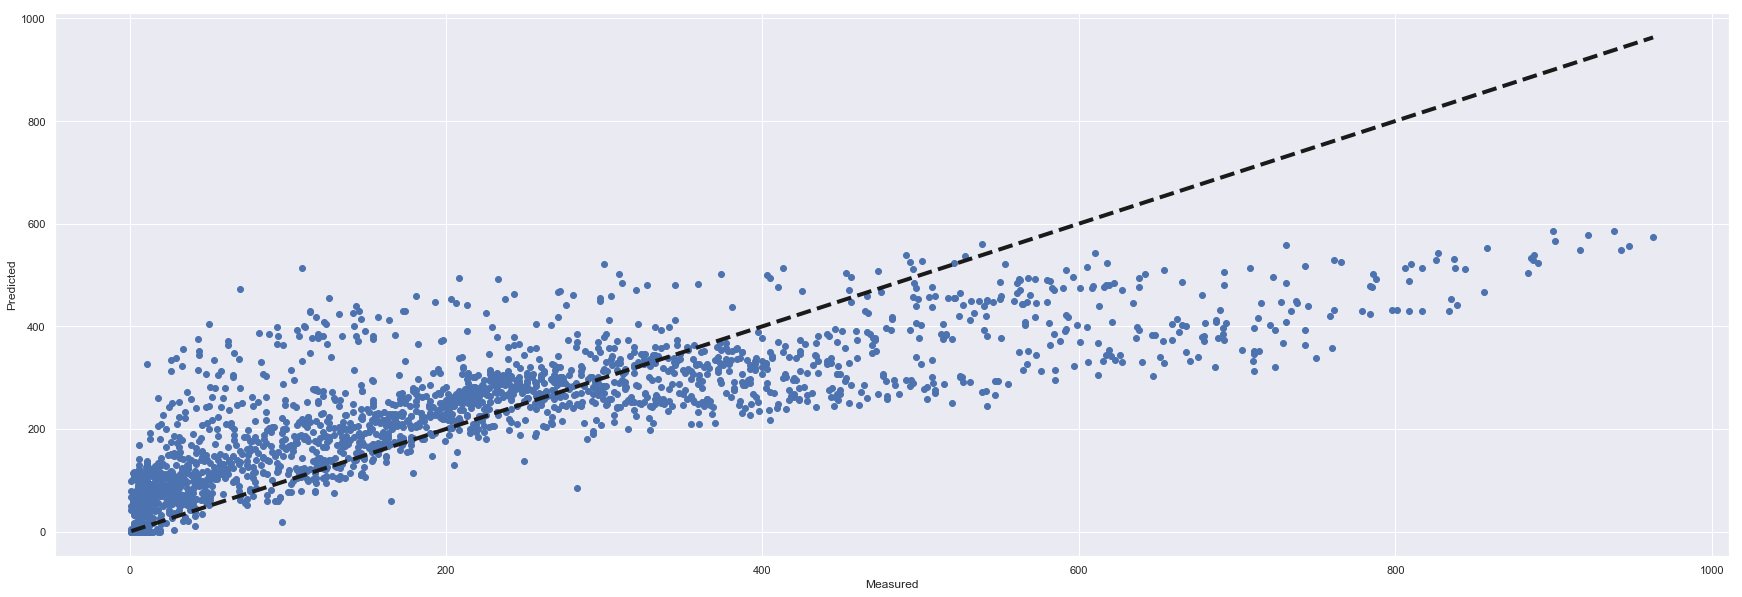

In [84]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), y_pred)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

RMSE has improved from the latest 169.78 to 121.58 with simple linear regression on the dummified dataset and R2 of 0.11.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


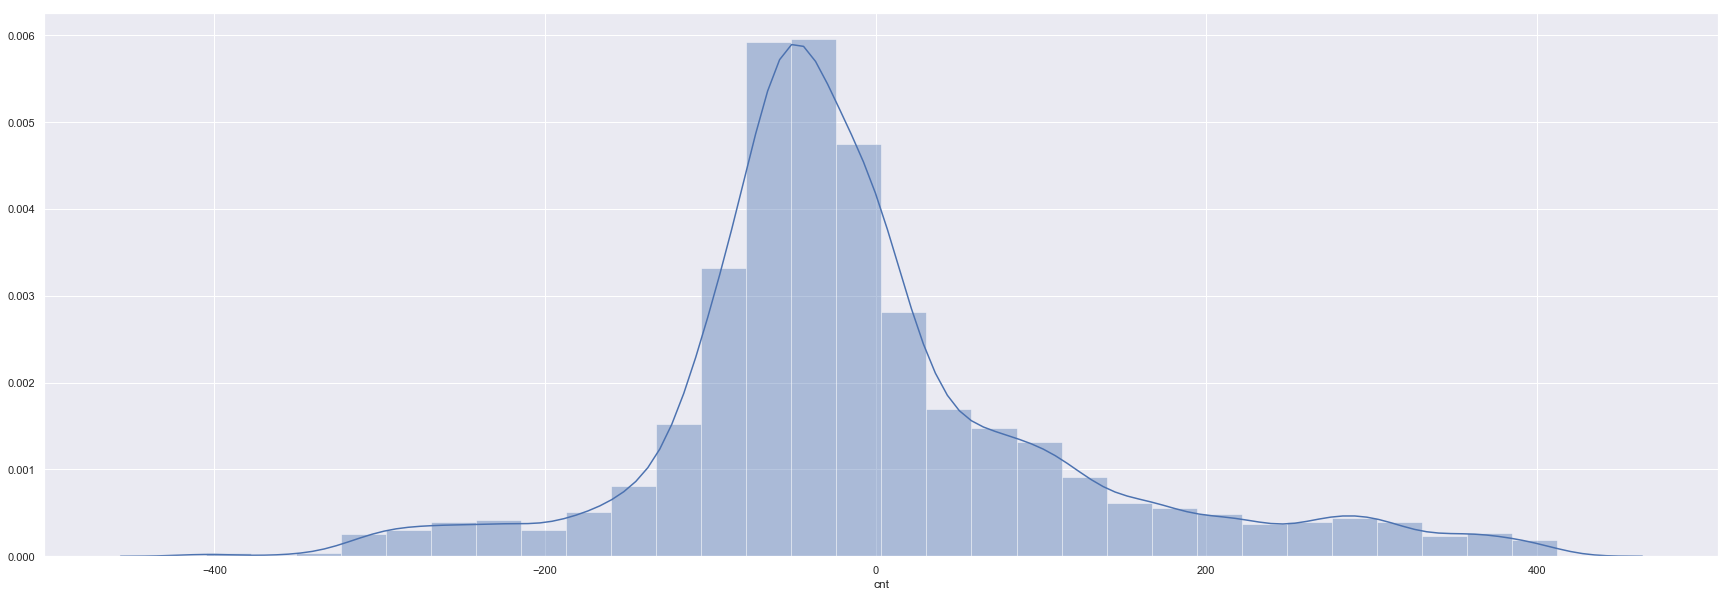

In [85]:
sns.distplot(y_test.compute() - y_pred, bins=30)

### 3.6 Ridge Reg

Next we try a ridge regression, which does not really perform better in overall.

In [86]:
with parallel_backend('dask'):

    ridge_model = Ridge(
        alpha=0.01
    )  # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely

    # fit model
    ridge_model.fit(X_train, y_train)

In [87]:
with parallel_backend('dask'):

    # making predection using the test set
    y_pred_ridge = ridge_model.predict(X_test)
    y_pred_ridge = [
        i if i >= 0 else 0 for i in y_pred
    ]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    y_pred_ridge = [round(x) for x in y_pred_ridge]

# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R2: %.2F" % r2_score(y_pred_ridge, y_test))

RMSE: 121.58
R2: 0.11


#### Visual representations of predictions and distribution of errors:

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


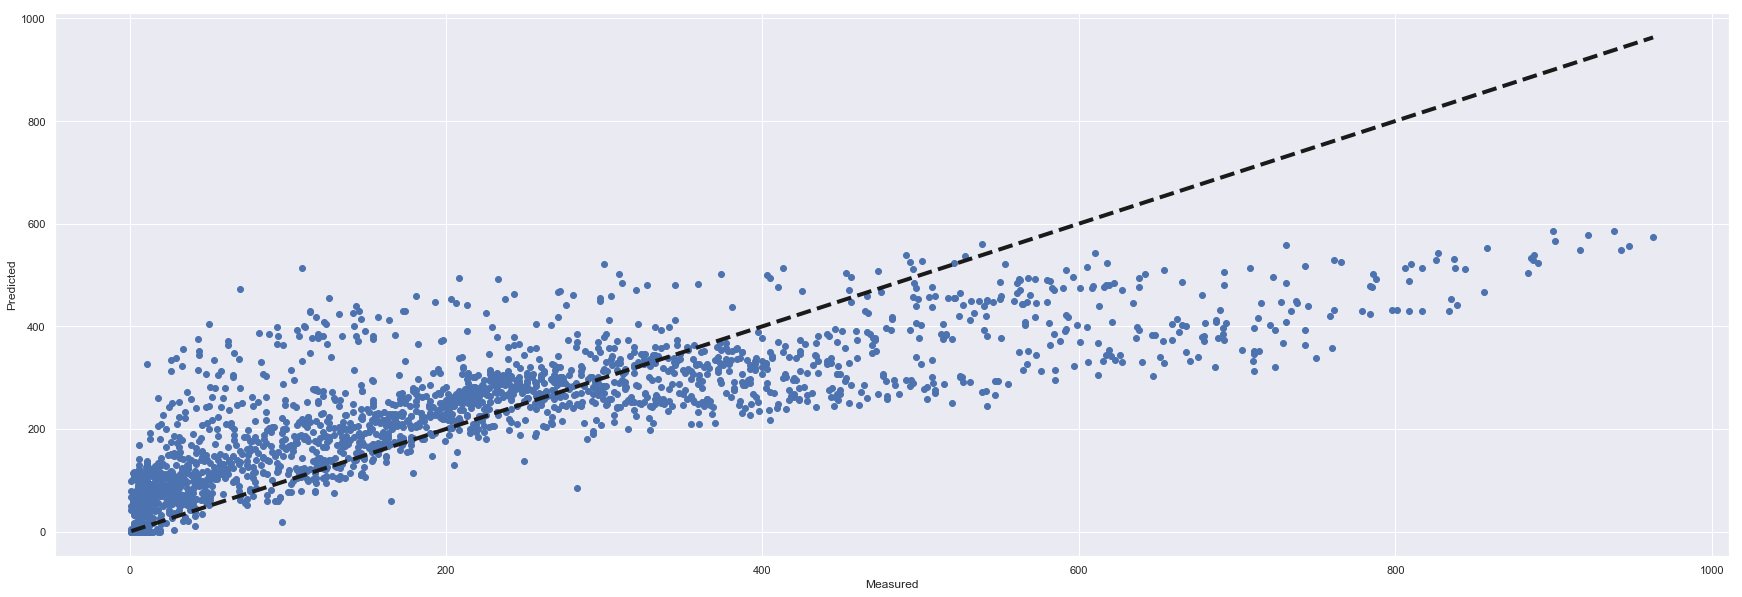

In [88]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), y_pred_ridge)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


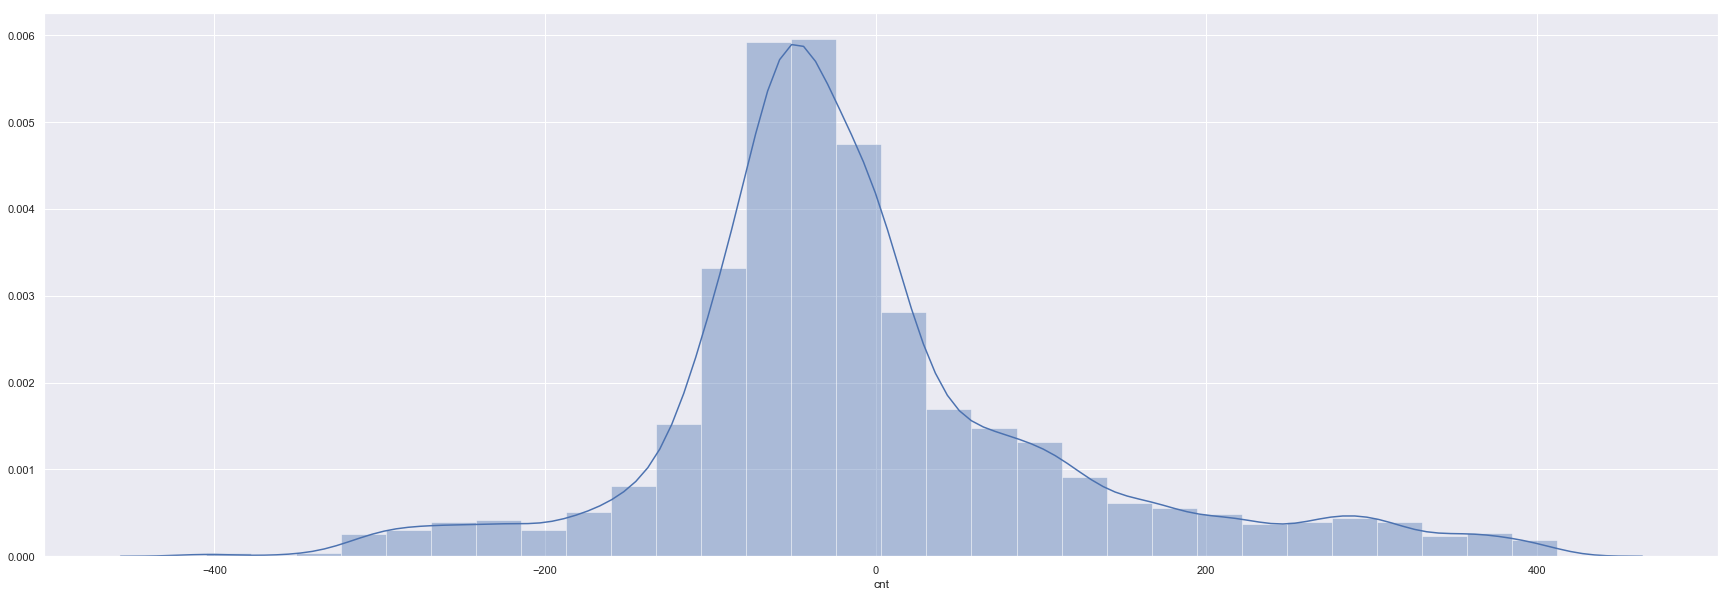

In [89]:
sns.distplot(y_test.compute() - y_pred_ridge, bins=30)

### 3.7 Lasso Reg

Trying lasso regression again does not improve.

In [90]:
with parallel_backend('dask'):

    lasso_model = Lasso(alpha=1)
    lasso_model.fit(X_train, y_train)

In [91]:
X_train.columns

Index(['temp', 'humidity', 'WCI', 'humidex', 'season_1', 'season_2',
       'season_3', 'season_4', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'year_0', 'year_1', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'is_workingday_0',
       'is_workingday_1', 'is_holiday_0', 'is_holiday_1'],
      dtype='object')

In [92]:
with parallel_backend('dask'):

    # making predection using the test set
    y_pred_lasso = lasso_model.predict(X_test)
    y_pred_lasso = [
        i if i >= 0 else 0 for i in y_pred
    ]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    y_pred_lasso = [round(x) for x in y_pred_lasso]

# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R2: %.2F" % r2_score(y_pred_lasso, y_test))

RMSE: 121.58
R2: 0.11


#### Visual representations of predictions and distribution of errors:

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


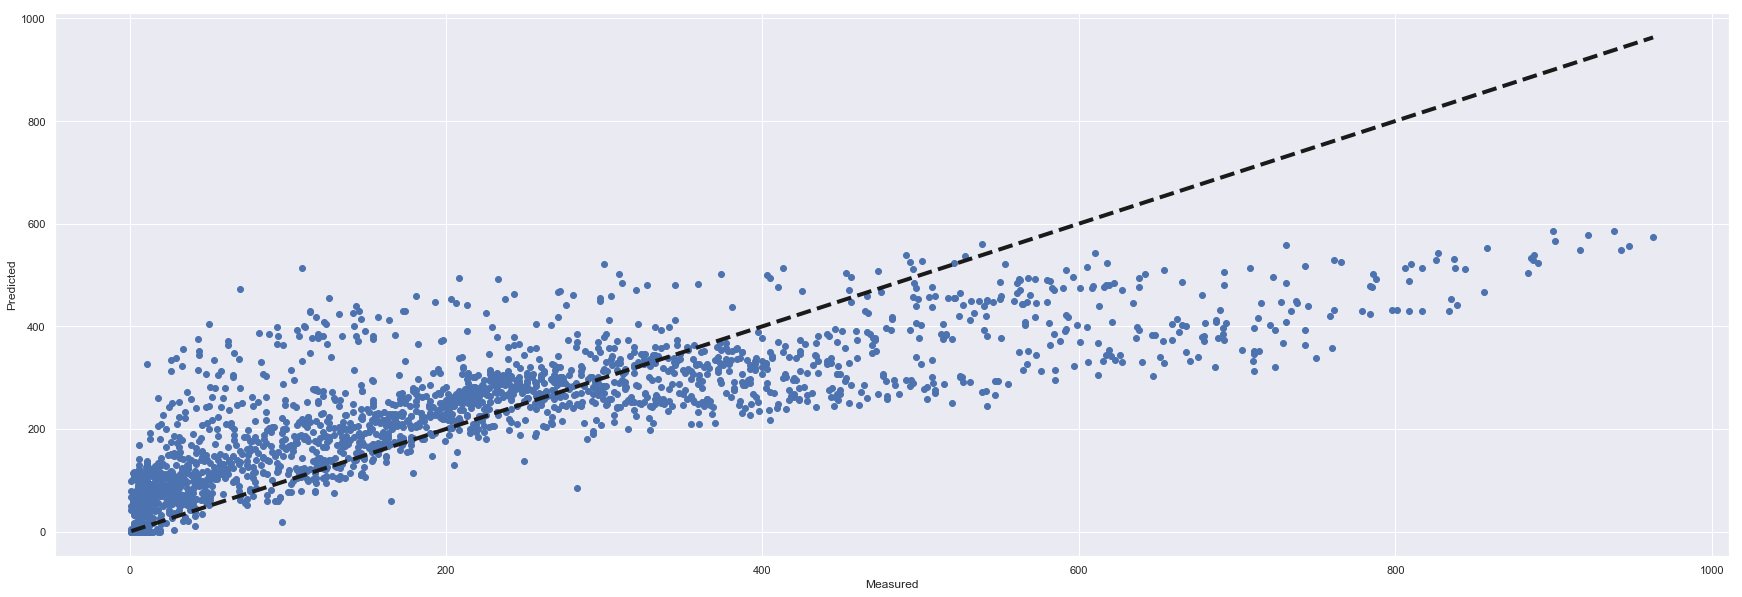

In [93]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), y_pred_lasso)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


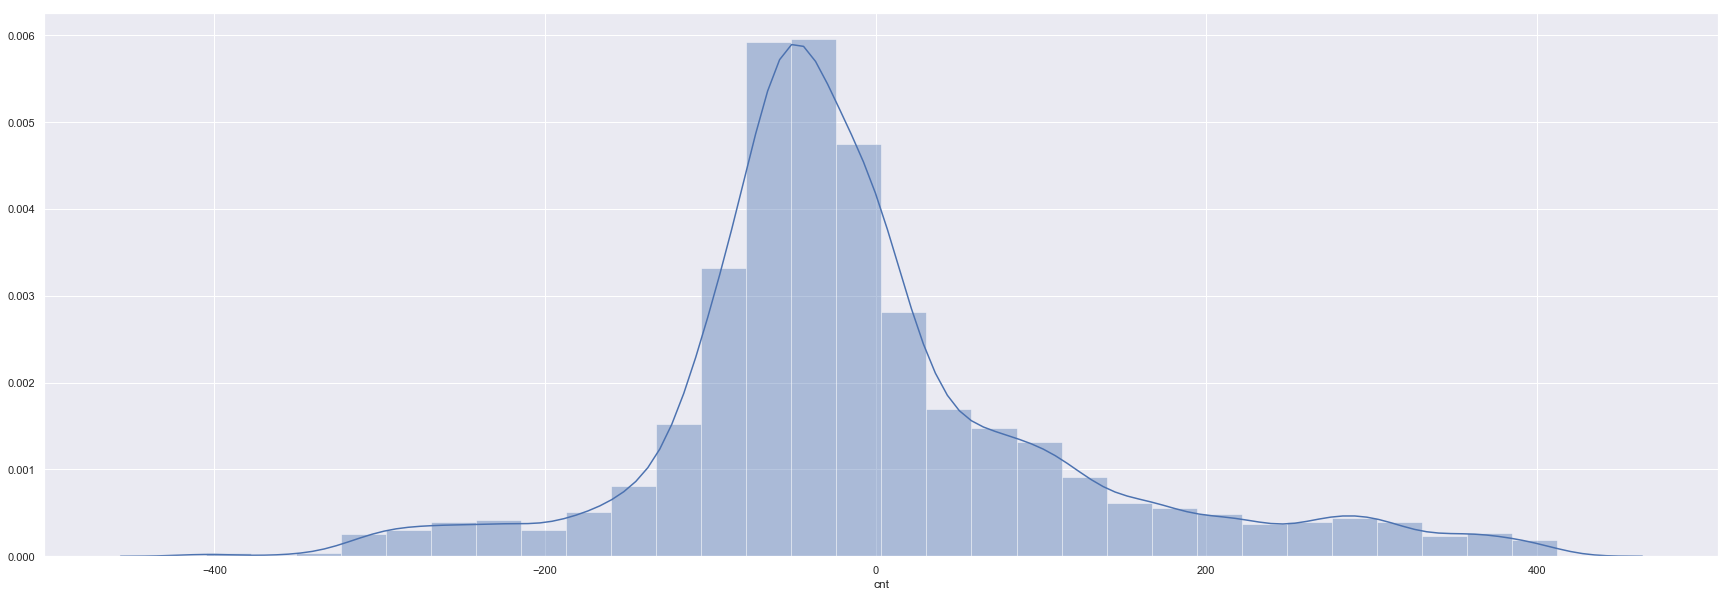

In [94]:
sns.distplot(y_test.compute() - y_pred_lasso, bins=30)

### 3.8 Random Forest

Random forest finally gives a lot better R2 score, which already indicates that we should optimize parameters for this model!

In [95]:
with parallel_backend('dask'):

    rf = RandomForestRegressor(n_estimators=1000, max_depth=10)
    rf.fit(X_train, y_train)

In [96]:
with parallel_backend('dask'):

    rf_pred = rf.predict(X_test)
    rf_pred = [i if i >= 0 else 0 for i in rf_pred]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    rf_pred = [round(x) for x in rf_pred]

    # root mean squared error
    print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, rf_pred)))
    print("R2: %.2F" % r2_score(y_test, rf_pred))

RMSE: 121.27
R2: 0.64


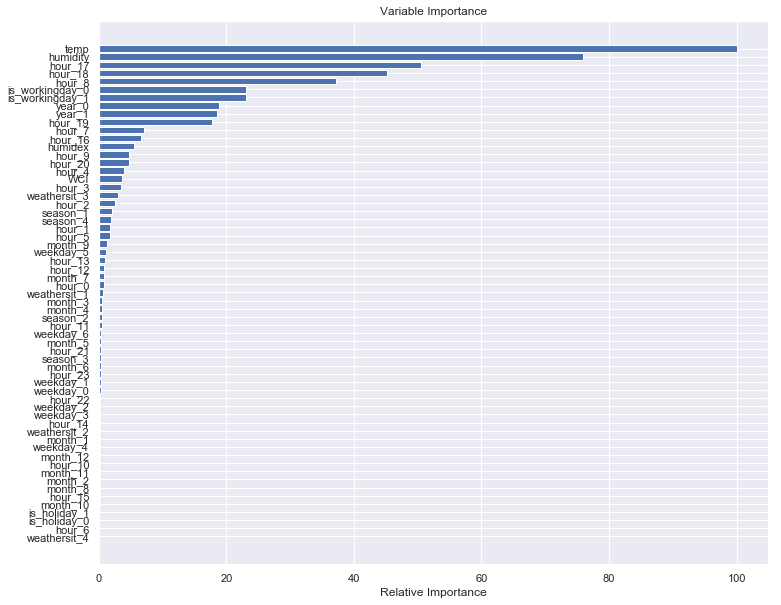

In [97]:
feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

#### Visual representations of predictions and distribution of errors:

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


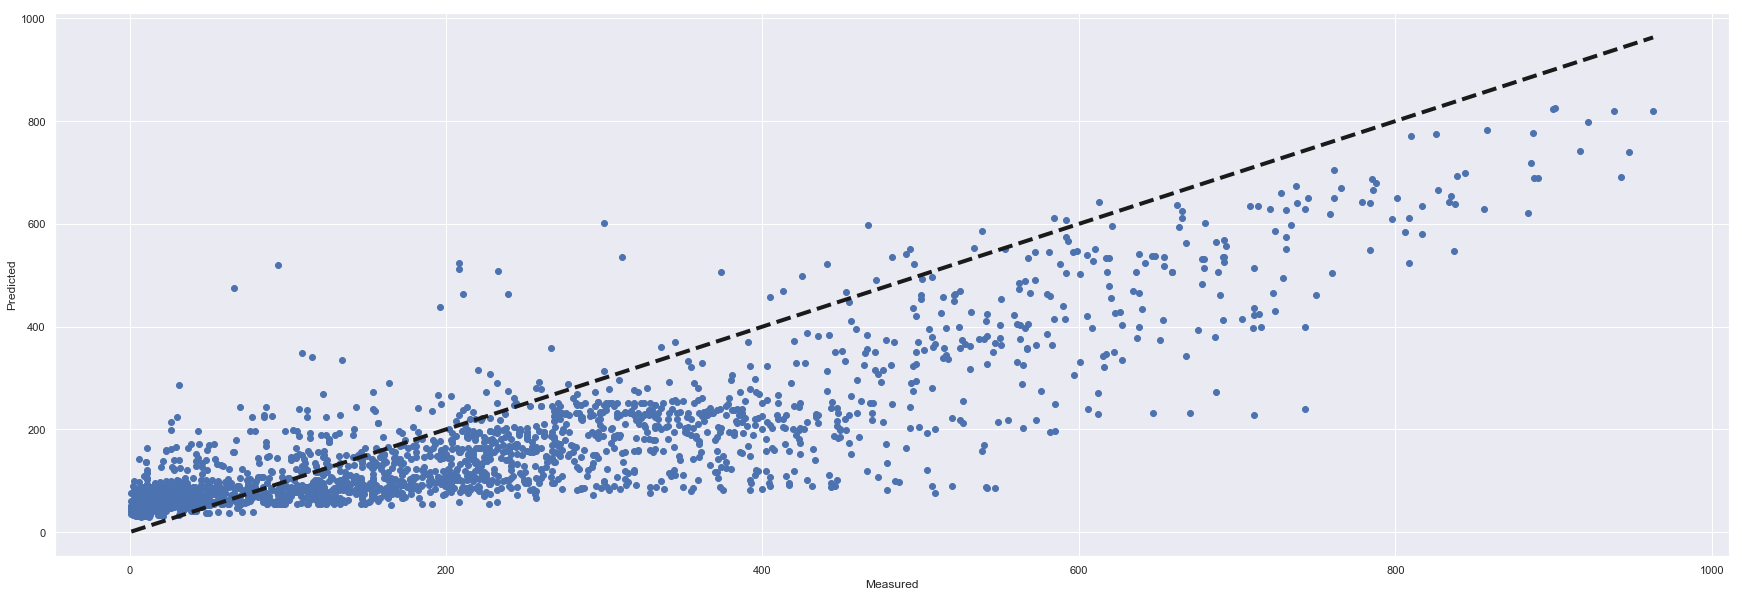

In [98]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), rf_pred)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


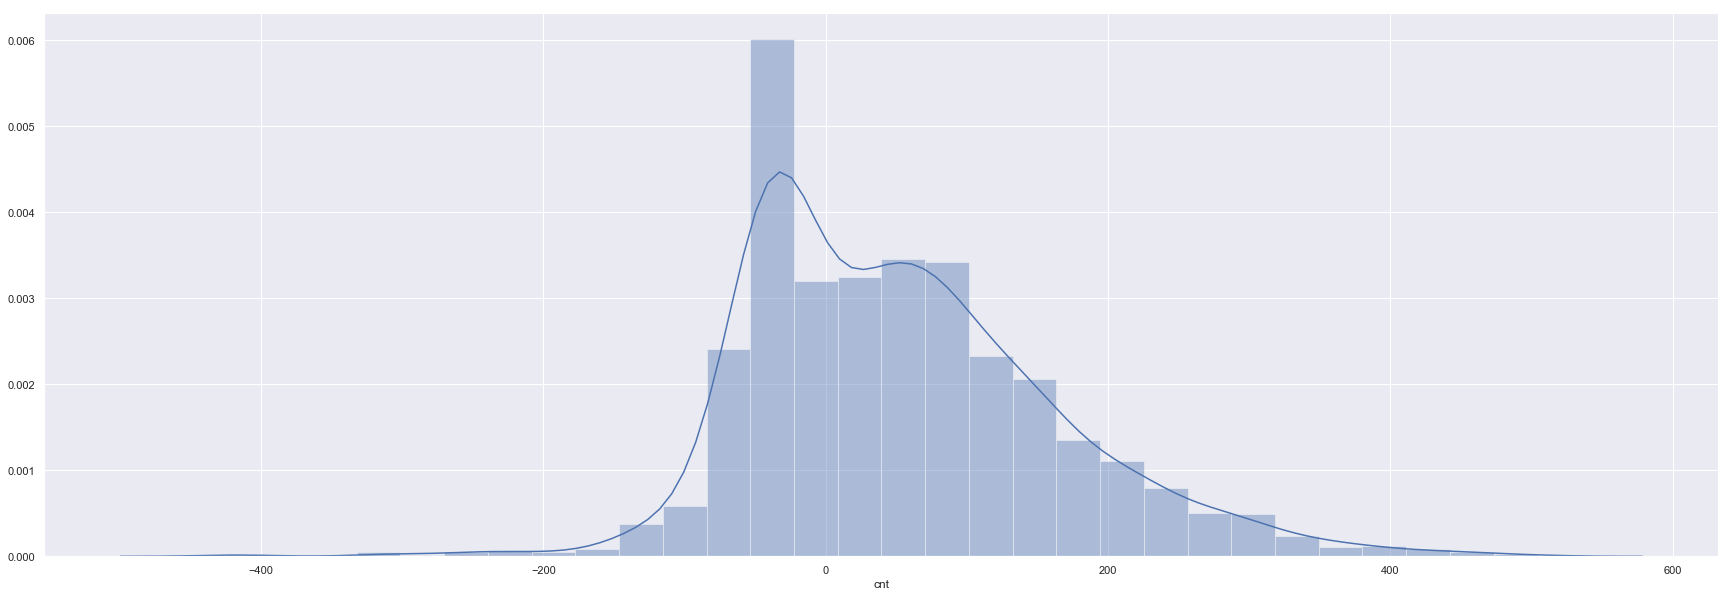

In [99]:
sns.distplot(y_test.compute() - rf_pred, bins=30)

### 3.9 Gradient Boosting

Gradient boosting even provides us with a higher R2, thus we will also optimize parameters for this model.

In [100]:
with parallel_backend('dask'):

    model_gbr = GradientBoostingRegressor()
    model_gbr.fit(X_train, y_train)
    prediction_gbr = model_gbr.predict(X_test)

    prediction_gbr = [
        i if i >= 0 else 0 for i in prediction_gbr
    ]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    prediction_gbr = [round(x) for x in prediction_gbr]

In [101]:
# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, prediction_gbr)))
print("R2: %.2F" % r2_score(y_test, prediction_gbr))

RMSE: 111.85
R2: 0.69


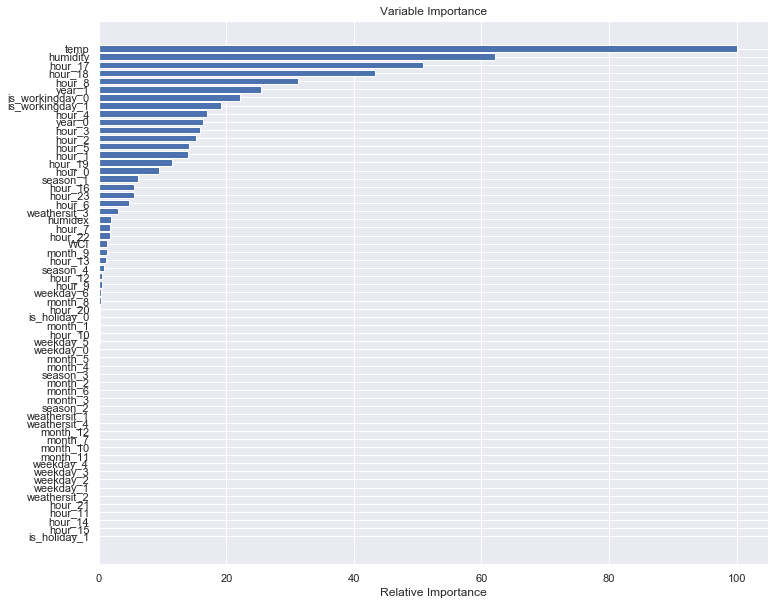

In [102]:
feature_importance = model_gbr.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

#### Visual representations of predictions and distribution of errors:

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


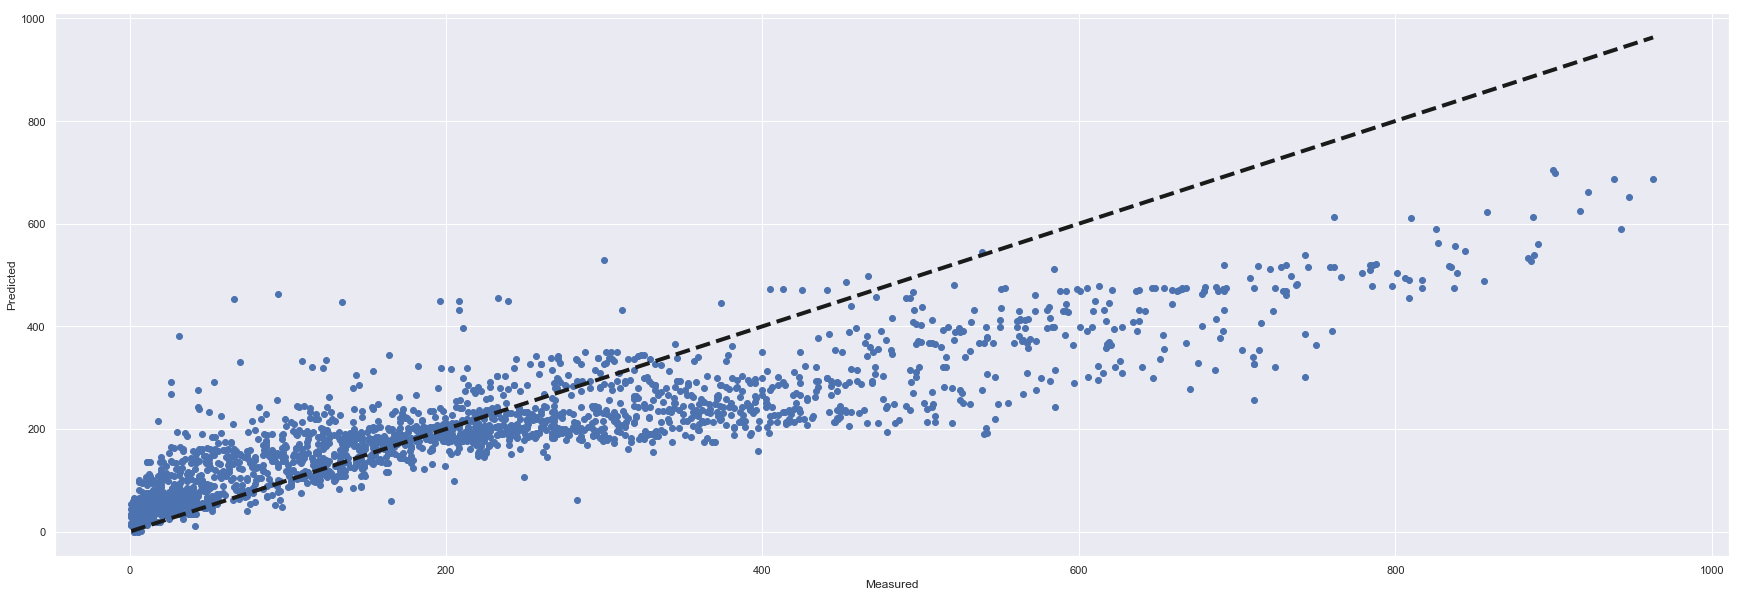

In [103]:
fig, ax = plt.subplots()
ax.scatter(y_test.compute(), prediction_gbr)
ax.plot([y_test.compute().min(), y_test.compute().max()], [y_test.compute().min(), y_test.compute().max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

### 3.10 XGBoost

Also XGBoost provides us with a good initial score, therefore we will also optimize its parameters in the next chapter.

In [104]:
# !pip install xgboost
import xgboost as xgb

In [117]:
with parallel_backend('dask'):

    model_xgb = xgb.XGBRegressor()

    model_xgb.fit(X_train.compute(), y_train.compute())
    xgb_predictions = model_xgb.predict(X_test.compute())

    xgb_predictions = [
        i if i >= 0 else 0 for i in xgb_predictions
    ]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    xgb_predictions = [round(x) for x in xgb_predictions]

ValueError: DataFrame for label cannot have multiple columns

In [ ]:
# root mean squared error
print("RMSE: %.2f" % da.sqrt(mean_squared_error(y_test, xgb_predictions)))
print("R2: %.2F" % r2_score(y_test, xgb_predictions))

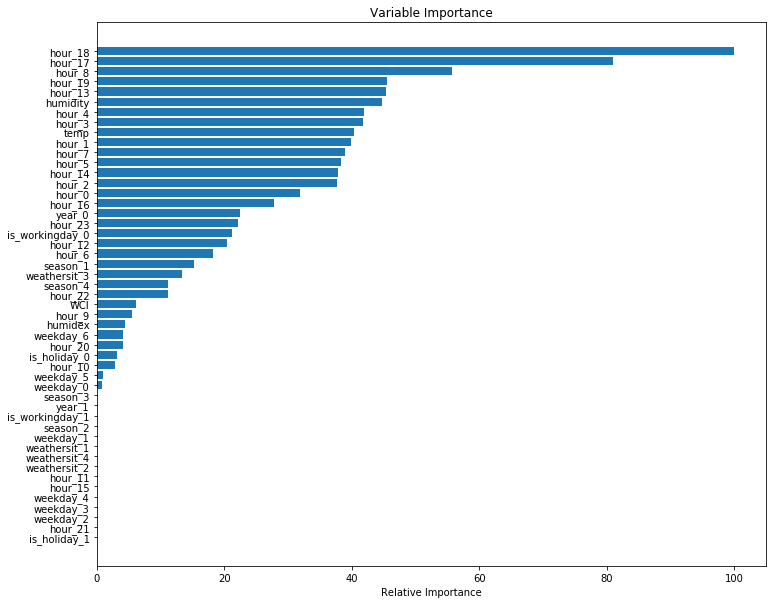

In [261]:
feature_importance = model_xgb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

#### Visual representations of predictions and distribution of errors:

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


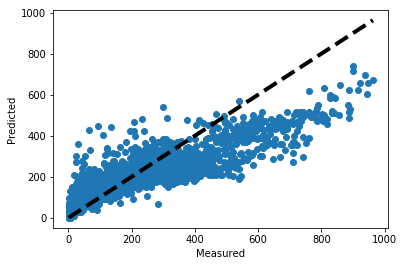

In [262]:
fig, ax = plt.subplots()
ax.scatter(y_test, xgb_predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

## 4 Model Optimization
### 4.1 Random Forest

Using grid search as we know that random forest is a good fit for this problem:

In [ ]:
# Grid Search

parameters_rf = [
    {
        "n_estimators": [250],
        "max_features": ["auto", "sqrt", "log2"],
    }
]

with parallel_backend('dask'):
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=parameters_rf)
    grid_search_rf = grid_search_rf.fit(X_train, y_train)
    best_parameters_rf = grid_search_rf.best_params_
    best_accuracy_rf = grid_search_rf.best_score_

In [264]:
best_parameters_rf

{'max_features': 'auto', 'n_estimators': 250}

In [265]:
best_accuracy_rf
# 0.58

0.5872342567654085

In [266]:
# Random Forest Regression model
# Use the best parameters found from above to build the model
with parallel_backend('dask'):
    regressor = RandomForestRegressor(n_estimators=250, max_features="auto")
    regressor.fit(X_train, y_train)

    # Predicting the values

    rf_pred_2 = regressor.predict(X_test)

In [267]:
rf_pred_2 = [
    i if i >= 0 else 0 for i in rf_pred_2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
rf_pred_2 = [round(x) for x in rf_pred_2]

In [268]:
# Comparing predicted values with true values in testing set

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, rf_pred_2)))
print("R2: %.2F" % r2_score(y_test, rf_pred_2))

#0.83

RMSE: 80.47
R2: 0.84


#### Visual representations of predictions and distribution of errors:

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


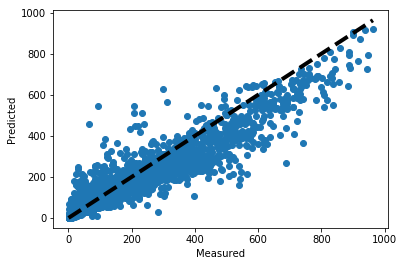

In [269]:
fig, ax = plt.subplots()
ax.scatter(y_test, rf_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

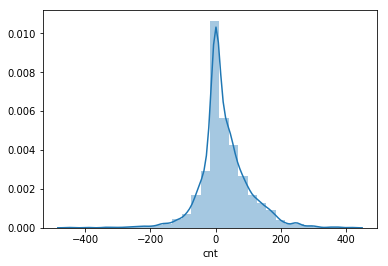

In [270]:
sns.distplot(y_test - rf_pred_2, bins=30)

### 4.2 Gradient Boosting

In [271]:
# Grid Search
parameters_bgr = [
    {
        "n_estimators": [700],
        "learning_rate": [ 0.1],
        "max_depth": [5],
        "max_features": ["auto", "sqrt", "log2"],
        "min_samples_leaf": [3],
    }
]

with parallel_backend('dask'):
    grid_search_gbr = GridSearchCV(estimator=model_gbr, param_grid=parameters_bgr)
    grid_search_gbr = grid_search_gbr.fit(X_train, y_train)
    best_parameters_gbr = grid_search_gbr.best_params_
    best_accuracy_gbr = grid_search_gbr.best_score_

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [272]:
# check the best parameters to be used
best_parameters_gbr

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'n_estimators': 700}

In [273]:
best_accuracy_gbr
# 0.8448552199196931

0.837883385838199

In [274]:
with parallel_backend('dask'):
    
    # Use the best parameters found from above to build the model
    gbr_new = GradientBoostingRegressor(
        n_estimators=700,
        max_features="log2",
        max_depth=7,
        learning_rate=0.1,
        min_samples_leaf=3,
    )

    gbr_new.fit(X_train, y_train)

    # Predicting the values
    gbr_pred_2 = gbr_new.predict(X_test)

    gbr_pred_2 = [
        i if i >= 0 else 0 for i in gbr_pred_2
    ]  # in case a value is predicted as minus

    # round prediction count to the nearest integer
    gbr_pred_2 = [round(x) for x in gbr_pred_2]

In [279]:
# Comparing predicted values with true values in testing set
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, gbr_pred_2)))
print("R2: %.2F" % r2_score(y_test, gbr_pred_2))

RMSE: 64.19
R2: 0.90


#### Visual representations of predictions and distribution of errors:

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


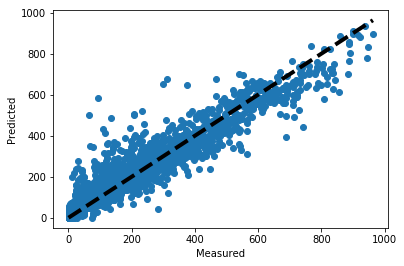

In [280]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

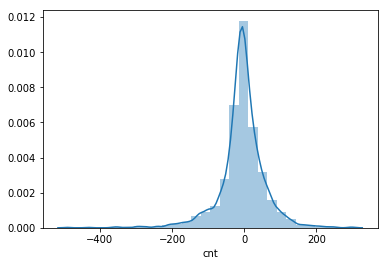

In [281]:
sns.distplot(y_test - gbr_pred_2, bins=30)

#### Cross Validation

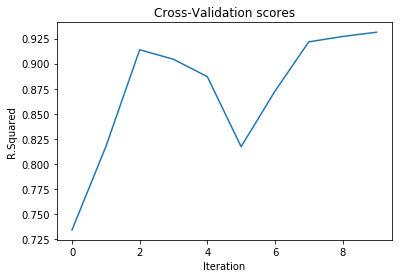

R-squared::[0.73422423 0.81729953 0.91386341 0.90432338 0.88700745 0.81723162
 0.87253722 0.92170852 0.92706083 0.93129547]
Mean Accuracy::0.8688175852169495


In [282]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

predict = cross_val_predict(gbr_new, X_train, y_train, cv=10)

# Evaluating model in cross-validation iteration
r2_scores = cross_val_score(gbr_new, X_train, y_train, cv=10)
mse = cross_val_score(
    gbr_new, X_train, y_train, cv=10, scoring="neg_mean_squared_error"
)
accuracy = cross_val_score(estimator=gbr_new, X=X_train, y=y_train, cv=10)

fig, ax = plt.subplots()
ax.plot(range(0, 10), r2_scores)
ax.set_xlabel("Iteration")
ax.set_ylabel("R.Squared")
ax.set_title("Cross-Validation scores")
plt.show()


print("R-squared::{}".format(r2_scores))
print("Mean Accuracy::{}".format(accuracy.mean()))

### 4.3 XGBoost

In [283]:
# Grid Search
parameters_xgb = [
    {
        "colsample_bytree": [0.3],
        "learning_rate": [0.1],
        "max_depth": [5],
        "n_estimators": [700],
    }
]

with parallel_backend('dask'):
    grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=parameters_xgb)
    grid_search_xgb = grid_search_xgb.fit(X_train, y_train)
    best_parameters_xgb = grid_search_xgb.best_params_
    best_accuracy_xgb = grid_search_xgb.best_score_

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost

In [284]:
best_parameters_xgb

{'colsample_bytree': 0.3,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 700}

In [285]:
best_accuracy_xgb

0.8355389262924033

In [286]:
with parallel_backend('dask'):

    model_xgb1 = xgb.XGBRegressor(
        colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=700
    )

    model_xgb1.fit(X_train, y_train)

    # Predicting the values
    xgb_pred_2 = model_xgb1.predict(X_test)
    xgb_pred_2 = [
        i if i >= 0 else 0 for i in xgb_pred_2
    ]  # in case a value is predicted as minus

# round prediction count to the nearest integer
xgb_pred_2 = [round(x) for x in xgb_pred_2]

In [287]:
# Comparing predicted values with true values in testing set

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, xgb_pred_2)))
print("R2: %.2F" % r2_score(y_test, xgb_pred_2))

RMSE: 66.56
R2: 0.89


#### Visual representations of predictions and distribution of errors:

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


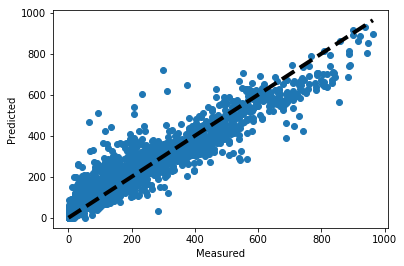

In [288]:
fig, ax = plt.subplots()
ax.scatter(y_test, xgb_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

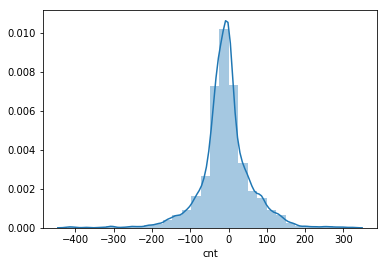

In [289]:
sns.distplot(y_test - xgb_pred_2, bins=30)

#### Cross Validation

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a f

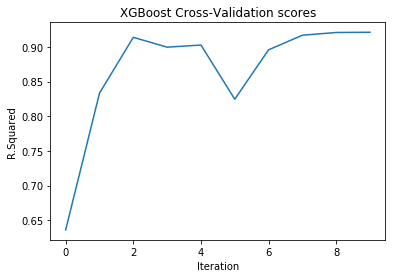

R-squared::[0.6360383  0.8332527  0.9138852  0.89965595 0.90273948 0.82457842
 0.8958325  0.91689268 0.92082448 0.92118793]
Mean Accuracy::0.866488763310745


In [290]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

predict = cross_val_predict(model_xgb1, X_train, y_train, cv=10)

# Evaluating model in cross-validation iteration
r2_scores_xgb = cross_val_score(model_xgb1, X_train, y_train, cv=10)
mse_xgb = cross_val_score(
    model_xgb1, X_train, y_train, cv=10, scoring="neg_mean_squared_error"
)
accuracy_xgb = cross_val_score(estimator=model_xgb1, X=X_train, y=y_train, cv=10)


fig, ax = plt.subplots()
ax.plot(range(0, 10), r2_scores_xgb)
ax.set_xlabel("Iteration")
ax.set_ylabel("R.Squared")
ax.set_title("XGBoost Cross-Validation scores")
plt.show()


print("R-squared::{}".format(r2_scores_xgb))
print("Mean Accuracy::{}".format(accuracy_xgb.mean()))

### 4.4 Stacking
The main idea behind the structure of a stacked generalization is to use one or more first level models, make predictions using these models and then use these predictions as features to fit one or more second level models on top. To avoid overfitting, cross-validation is usually used to predict the OOF (out-of-fold) part of the training set. 

In [293]:
# !pip install vecstack
from vecstack import stacking

In [294]:
models = [model_xgb1, regressor, model_gbr]

S_train, S_test = stacking(
    models,
    X_train,
    y_train,
    X_test,
    regression=True,
    mode="oof_pred_bag",
    needs_proba=False,
    save_dir=None,
    metric=r2_score,
    n_folds=4,
    shuffle=True,
    random_state=0,
    verbose=2,
)

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [XGBRegressor]
    fold  0:  [0.94213076]
    fold  1:  [0.93803572]
    fold  2:  [0.94056685]
    fold  3:  [0.93633464]
    ----
    MEAN:     [0.93926699] + [0.00223638]
    FULL:     [0.93927947]

model  1:     [RandomForestRegressor]
    fold  0:  [0.92773092]
    fold  1:  [0.92506768]
    fold  2:  [0.92706272]
    fold  3:  [0.92142061]
    ----
    MEAN:     [0.92532048] + [0.00245553]
    FULL:     [0.92533837]

model  2:     [GradientBoostingRegressor]
    fold  0:  [0.77949614]
    fold  1:  [0.79422514]
    fold  2:  [0.79330411]
    fold  3:  [0.80162193]
    ----
    MEAN:     [0.79216183] + [0.00799180]
    FULL:     [0.79207536]



In [295]:
stacked_model = xgb.XGBRegressor(
    colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=700
)
stacked_model = stacked_model.fit(S_train, y_train)
stacked_pred = stacked_model.predict(S_test)

stacked_pred = [
    i if i >= 0 else 0 for i in stacked_pred
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
stacked_pred = [round(x) for x in stacked_pred]

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred)))
print("R2: %.3F" % r2_score(y_test, stacked_pred))

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 70.10
R2: 0.879


## second stacking without GBT

In [301]:
models2 = [model_xgb1, regressor]

S_train, S_test = stacking(
    models2,
    X_train,
    y_train,
    X_test,
    regression=True,
    mode="oof_pred_bag",
    needs_proba=False,
    save_dir=None,
    metric=r2_score,
    n_folds=4,
    shuffle=True,
    random_state=0,
    verbose=2,
)

task:         [regression]
metric:       [r2_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [XGBRegressor]
    fold  0:  [0.94213076]
    fold  1:  [0.93803572]
    fold  2:  [0.94056685]
    fold  3:  [0.93633464]
    ----
    MEAN:     [0.93926699] + [0.00223638]
    FULL:     [0.93927947]

model  1:     [RandomForestRegressor]
    fold  0:  [0.92753597]
    fold  1:  [0.92530778]
    fold  2:  [0.92604689]
    fold  3:  [0.92112670]
    ----
    MEAN:     [0.92500433] + [0.00237825]
    FULL:     [0.92502930]



In [304]:
stacked_model2 = xgb.XGBRegressor(
    colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=700
)
stacked_model2 = stacked_model2.fit(S_train, y_train)
stacked_pred2 = stacked_model2.predict(S_test)

stacked_pred2 = [
    i if i >= 0 else 0 for i in stacked_pred2
]  # in case a value is predicted as minus

# round prediction count to the nearest integer
stacked_pred2 = [round(x) for x in stacked_pred2]

print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred2)))
print("R2: %.3F" % r2_score(y_test, stacked_pred2))

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


RMSE: 69.83
R2: 0.880


#### Visual representations of predictions and distribution of errors:

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


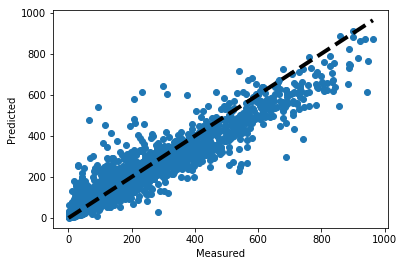

In [296]:
fig, ax = plt.subplots()
ax.scatter(y_test, stacked_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

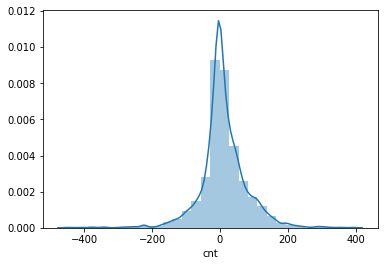

In [297]:
sns.distplot(y_test - stacked_pred, bins=30)

## 5 Conclusion

### 5.1 Compare Models

old:

Random Forest

RMSE: 83.86

R2: 0.83

XGBoost

RMSE: 70.97

R2: 0.88

Gradient Boosting Regressor

RMSE: 66.19

R2: 0.89

Stacked Model

RMSE: 76.08

R2: 0.86

new:

In [305]:
print("Random Forest")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, rf_pred_2)))
print("R2: %.2F" % r2_score(y_test, rf_pred_2))
print("XGBoost")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, xgb_pred_2)))
print("R2: %.2F" % r2_score(y_test, xgb_pred_2))
print("Gradient Boosting Regressor")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, gbr_pred_2)))
print("R2: %.2F" % r2_score(y_test, gbr_pred_2))
print("Stacked Model")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred)))
print("R2: %.2F" % r2_score(y_test, stacked_pred))
print("Stacked Model2")
print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, stacked_pred2)))
print("R2: %.2F" % r2_score(y_test, stacked_pred2))

Random Forest
RMSE: 80.47
R2: 0.84
XGBoost
RMSE: 66.56
R2: 0.89
Gradient Boosting Regressor
RMSE: 64.19
R2: 0.90
Stacked Model
RMSE: 70.10
R2: 0.88
Stacked Model2
RMSE: 69.83
R2: 0.88


### 5.3 Best prediction

The best model we got was achieved by Gradient Boosting Regressor and scored a R2 of 0.89. Below we can see (again) the graphical representation of the predictions compared to the actual count and the distribution of the errors. We can clearly see (also graphically) that the model fits the actual data fine and the errors are distributed around 0.

/Users/antoniaschulze/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


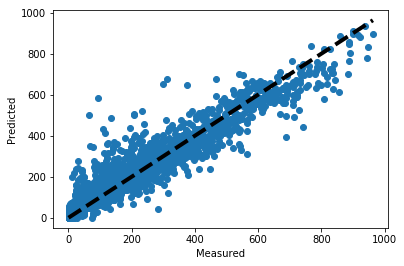

In [299]:
fig, ax = plt.subplots()
ax.scatter(y_test, gbr_pred_2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
fig.show()

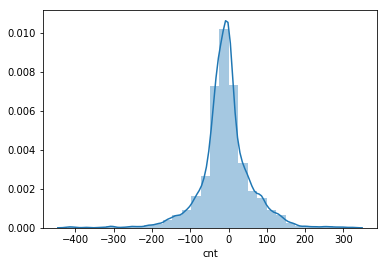

In [300]:
sns.distplot(y_test - xgb_pred_2, bins=30)

# 6 Wrap up

Finally we will point out our general work approach, difficulties and addidtional improvements that could be made.

### Work Approach
As usual for group projects we sat together at the very beginning to decide upon a approach and how to take further steps. This inluded splitting the work among group members to work efficiently. To be kept up to date we met occasionally and discussed outcomes and the progress.

### Difficulties
As the data was "clean" (except of a few outliers) from the beginning on, the largest difficulty during this project was splitting work efficiently and especially the computational limitations of our computer. This means that for example grid searches very time intensive and forced us to reconvene. 


### Possible Additional Improvements
- Pipelines could have been used to obtain a clearer workflow. However, we think that the focus on gaining higher model performance more value adding.
- Within the pipeline we could've created polynomial features in order to grasp non linear relationships between the dependent variables.
- External data could have been taken into account, although the implementation of this data has to be done carefully. For example, we could take into account crime rates by hour of day, or more specific location data within the city. 
- We could have used log transformation in order to avoid negative predictions instead of running our for loop. 